# 9. Figure 5

This notebook is used to create the panels of Figure 5.

Before starting, use 8.Co-abundance analysis notebook to generate:
- SC2_co-abundance.csv

Download data available at Metabolights [www.ebi.ac.uk/metabolights/MTBLS11236], study identifier MTBLS11236 and move to data folder:
- SC2_metabolite_IDs.csv - Metabolite metadata

In [1]:
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import scanpy as sc
import networkx as nx
from anndata import read_h5ad

import sys
sys.path.insert(0, '../functions/')
import pl
import utils

### Set plot style

In [2]:
%matplotlib inline
%config InlineBackend.figure_formats=['retina']
sns.set(rc={'figure.figsize':(5, 5),
            'legend.frameon':False},
        style='ticks',
        context='talk')

# Render figures with higher resolution.
plt.rcParams['figure.dpi']=200
# Save with transparent regions white background.
plt.rcParams['savefig.facecolor']='white'

### Set color palette

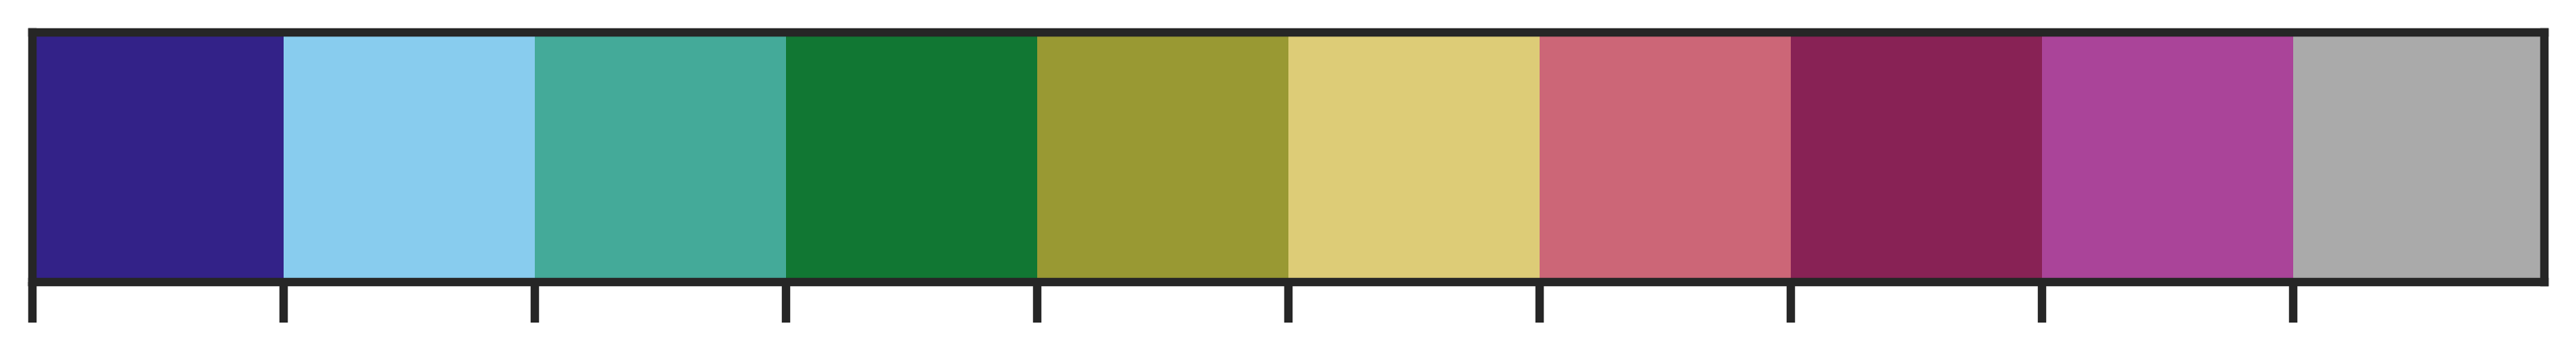

In [3]:
#color palette
palette = [(51,34,136),(136,204,238),(68,170,153),(17,119,51),(153,153,51),(221,204,119),(204,102,119),(136,34,85),(170,68,153),(170,170,170)]
palette = [(e[0]/255.0, e[1]/255.0, e[2]/255.0) for e in palette]
cmap = ListedColormap(palette)
sns.color_palette(palette=None,as_cmap=True)
sns.palplot(palette)

## Panel A

### Set paths

In [4]:
#input
data_dir = Path(r'../data')
data_path = data_dir / 'SC2_co-abundance.csv'

#output
plots_path =  Path(r'../') / 'figures' / 'figure_5'
plots_path.mkdir(parents=True, exist_ok=True)
sc.settings.figdir = plots_path

### Load data

In [5]:
#load data file
coabundance_df =  pd.read_csv(data_path)

### Density plot

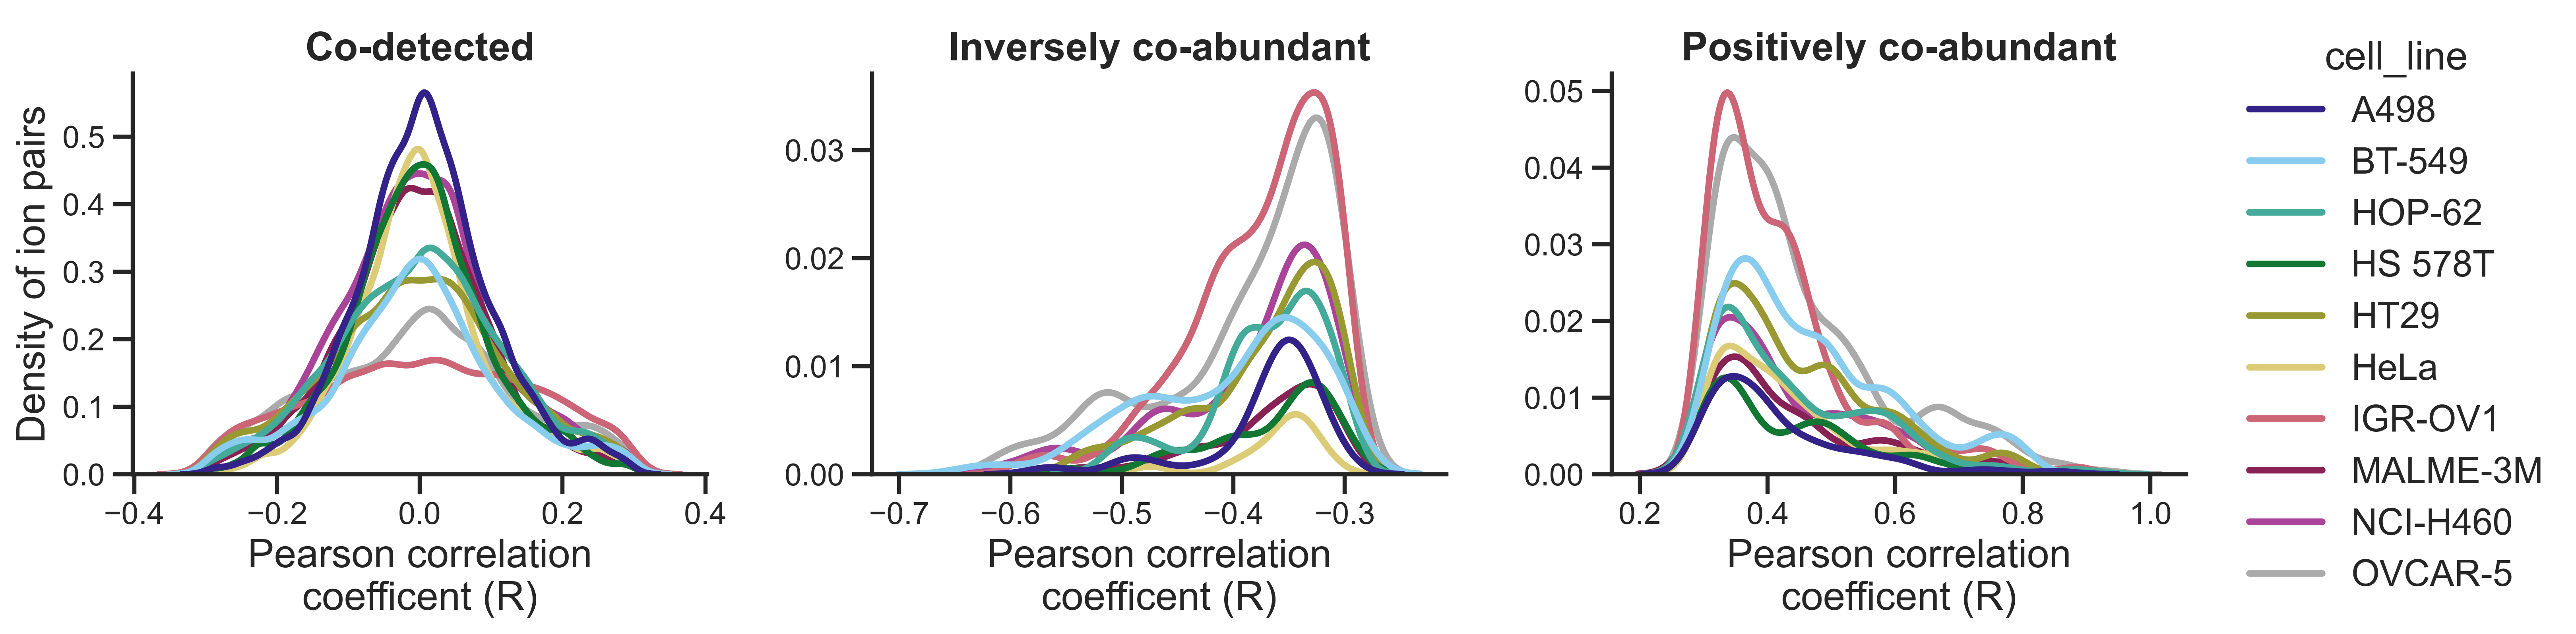

In [6]:
coabundance_sorted=coabundance_df.sort_values(by=['cell_line','group'])
g = sns.displot(coabundance_sorted,
                x='corr',
                hue='cell_line',
                palette=palette,
                common_norm=True,
                col='group',
                height=4,
                aspect=1.2,
                kind='kde',
                linewidth=3,
                bw_adjust=0.7,
                facet_kws={'sharey':False, 'sharex':False})

g.set_ylabels('Density of ion pairs', fontsize=18)
g.set_xlabels('Pearson correlation\ncoefficent (R)', fontsize=18)
for ax in g.axes:   
    ax[0].tick_params('both',labelsize=14)
    ax[1].tick_params('both',labelsize=14)
    ax[2].tick_params('both',labelsize=14)
    ax[0].set_title('Co-detected', weight ='bold', fontsize=18)
    ax[2].set_title('Positively co-abundant', weight ='bold', fontsize=18)
    ax[1].set_title('Inversely co-abundant', weight ='bold', fontsize=18)
    
plt.savefig(plots_path / 'panel_A.png', bbox_inches='tight')
plt.savefig(plots_path / 'panel_A.svg', bbox_inches='tight')

## Panel B

### Set paths

In [7]:
#input
data_dir = Path(r'../data')
data_path = data_dir / 'SC2_co-abundance.csv'

#output
plots_path =  Path(r'../') / 'figures' / 'figure_5'
plots_path.mkdir(parents=True, exist_ok=True)
sc.settings.figdir = plots_path

### Load data

In [8]:
#load data file
coabundance_df =  pd.read_csv(data_path)

In [9]:
#determine most positevely co-abundant ion-pairs
filt = coabundance_df[(coabundance_df['corr']>=0.5)
].groupby('ions').count().sort_values('ions', ascending=True).drop(['cell_line','cell_count',
                                                                      'proportion','corr','p-value','group'], axis=1).reset_index()

### Barplot

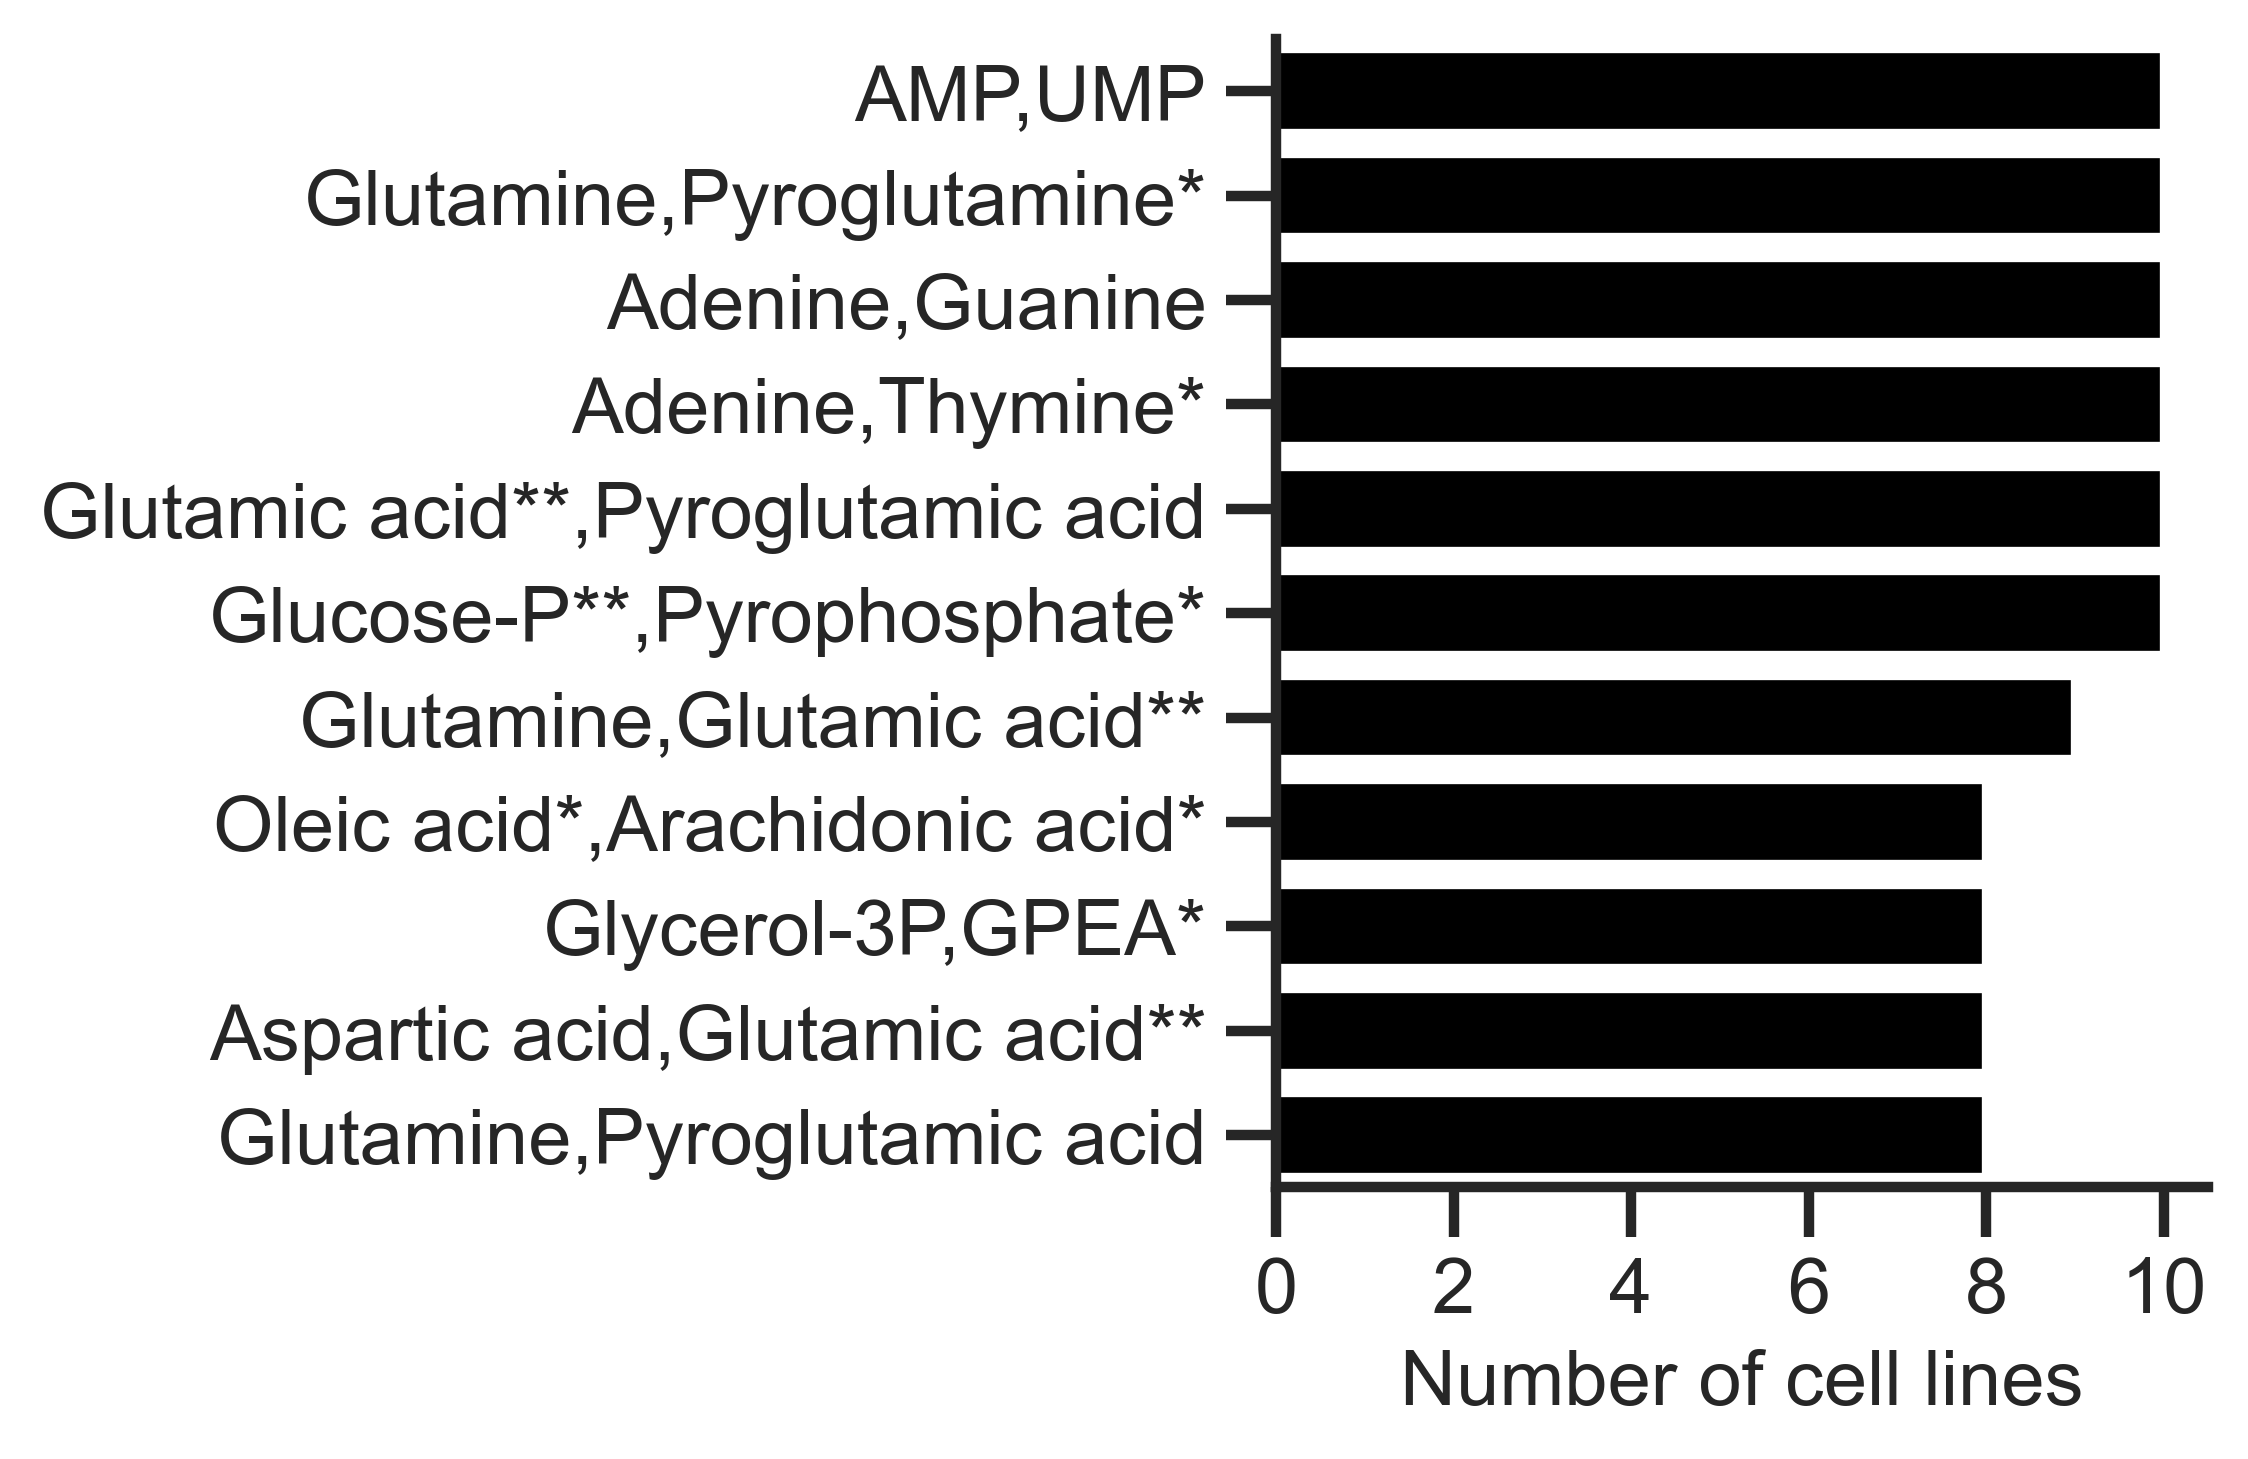

In [10]:
n_top = 11
top = filt.nlargest(n_top, columns='value')

ax = sns.catplot(data=top,
                 x='value',
                 y='ions',
                 orient='h',
                 kind='bar',
                 aspect=1.5,
                 height=4,
                 color='black',
                 legend=None)

ax.set_xlabels('Number of cell lines', fontsize=14)
ax.set_ylabels('')
ax.set_yticklabels(labels=['AMP,UMP', 'Glutamine,Pyroglutamine*', 'Adenine,Guanine', 'Adenine,Thymine*',
                           'Glutamic acid**,Pyroglutamic acid', 'Glucose-P**,Pyrophosphate*', 'Glutamine,Glutamic acid**',
                           'Oleic acid*,Arachidonic acid*','Glycerol-3P,GPEA*','Aspartic acid,Glutamic acid**',
                           'Glutamine,Pyroglutamic acid'])

plt.yticks(fontsize=14, rotation_mode=None)
plt.xticks(ticks=[0,2,4,6,8,10], fontsize=14, rotation_mode=None)
plt.tight_layout()

plt.savefig(plots_path / 'panel_B.png', bbox_inches='tight')
plt.savefig(plots_path / 'panel_B.svg', bbox_inches='tight')

## Panel C

### Set paths

In [11]:
input
data_dir = Path(r'../data')
data_path = data_dir / 'SC2_co-abundance.csv'
metabolite_path = data_dir / 'SC2_metabolite_IDs.csv'

#output
plots_path =  Path(r'../') / 'figures' / 'figure_5'
plots_path.mkdir(parents=True, exist_ok=True)
sc.settings.figdir = plots_path

### Load data

In [12]:
##load data file
coabundance_df =  pd.read_csv(data_path)

#load metabolites file
metabolite_ID = pd.read_csv(metabolite_path)

In [13]:
corr_filt = coabundance_df.loc[(coabundance_df['corr']>= 0.3)]
cell_name = ['A498','BT-549','HOP-62','HS 578T','HT29','HeLa','IGR-OV1','MALME-3M','NCI-H460','OVCAR-5']

In [14]:
G_graphs = {}

for cell in cell_name:
    G = nx.from_pandas_edgelist(corr_filt.loc[corr_filt['cell_line']==cell],source='col1', target='col2', edge_attr=True)
    G_graphs[cell] = G


class_attr = dict(zip(metabolite_ID['ion'], metabolite_ID['class']))

edge_weight = {}
for index, row in corr_filt.iterrows():    
    weight = tuple(sorted([row['col1'], row['col2']]))
    if weight not in edge_weight:
        edge_weight[weight] = row['corr']

for index in G_graphs:
    nx.set_node_attributes(G_graphs[index], name='class', values=class_attr)
    nx.set_edge_attributes(G_graphs[index], name='weight', values=edge_weight)

metrics = [] 
for index in G_graphs:
    pagerank = nx.pagerank(G_graphs[index], weight='weight', max_iter=500)
    for key, value in pagerank.items():
        metrics.append({'cell_line': index, 'ion': key, 'pagerank': value})

metrics_df = pd.DataFrame(metrics)
metrics_df['rank'] = metrics_df.groupby('cell_line')['pagerank'].rank(method='max', ascending=False)

### Dot plot

<Figure size 1200x800 with 0 Axes>

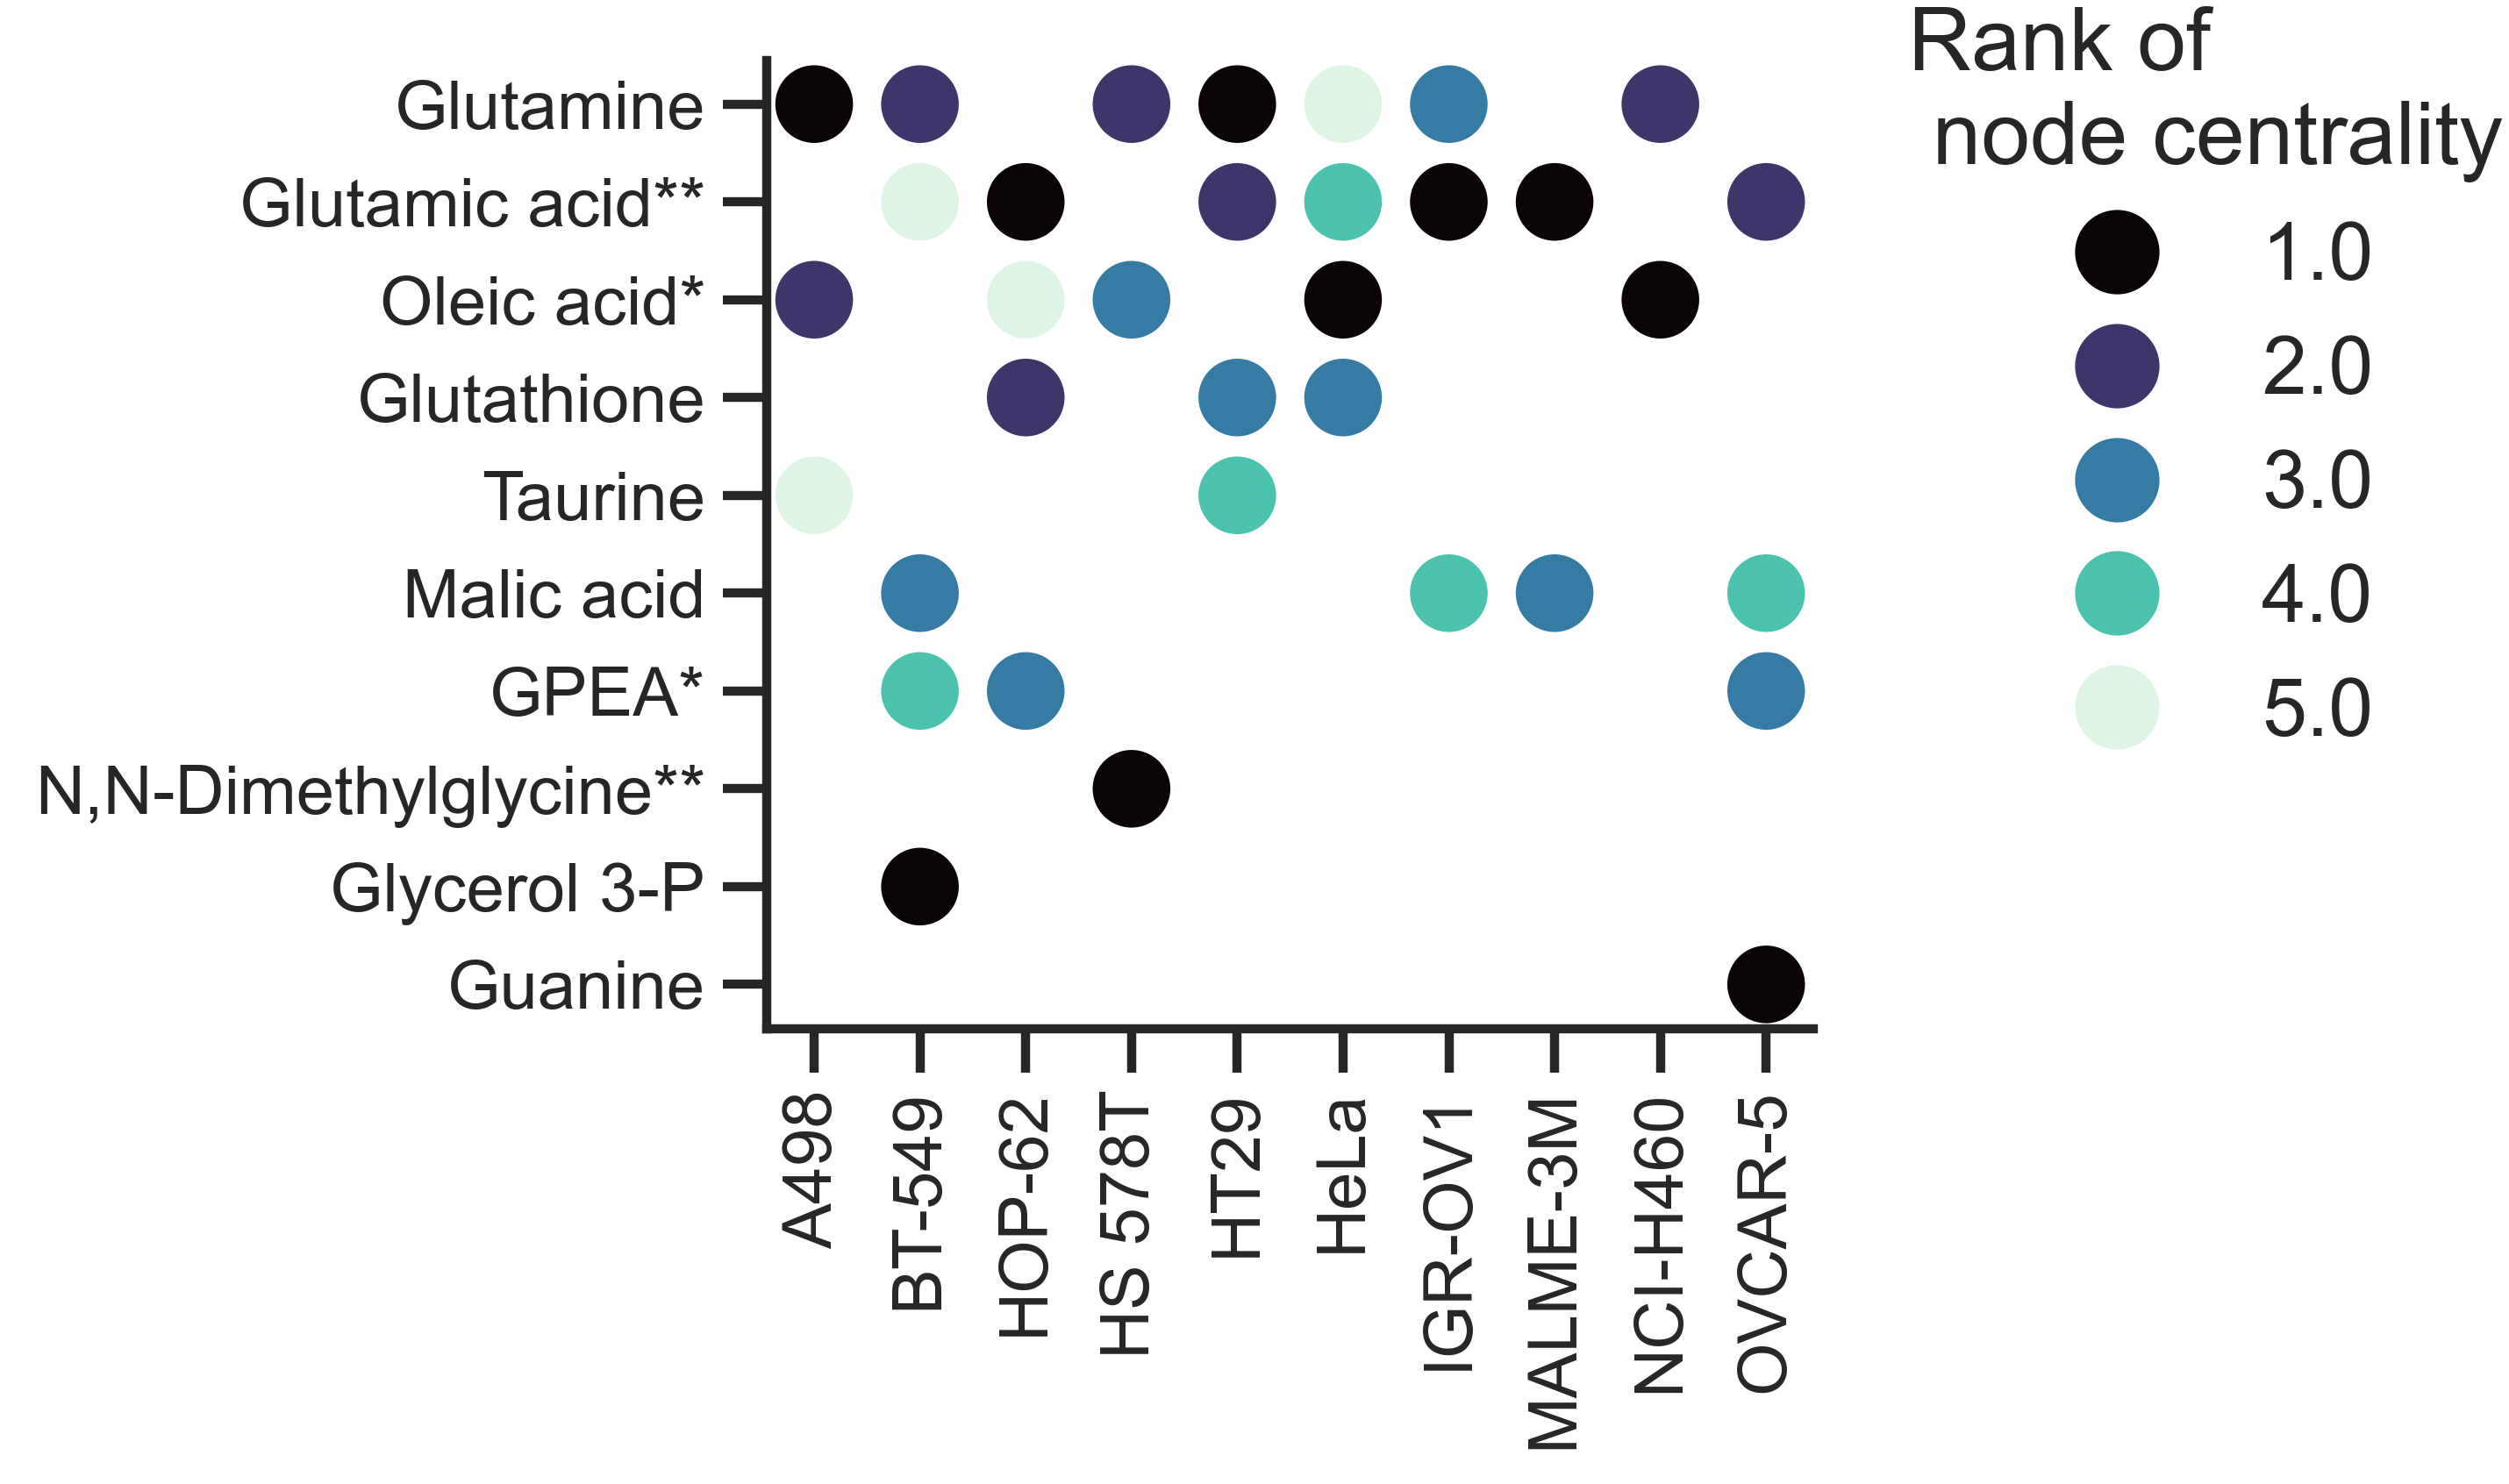

In [15]:
ion_list = ['C5H10N2O3-H', 'C5H9NO4-H', 'C18H34O2-H', 'C10H17N3O6S-H', 
            'C2H7NO3S-H',  'C4H6O5-H',  'C5H14NO6P-H', 'C4H9NO2-H',
            'C3H9O6P-H', 'C5H5N5O-H']
pagerank = metrics_df[metrics_df['ion'].isin(ion_list)]
pagerank = pagerank.loc[pagerank['rank']<=5.0]
pagerank['ion']= pd.Categorical(pagerank['ion'], categories=ion_list, ordered=True)
pagerank['cell_line'] = pd.Categorical(pagerank['cell_line'], categories=cell_name, ordered=True)
pagerank = pagerank.sort_values(by='ion')
pagerank = pagerank.sort_values(by='cell_line')

plt.figure(figsize=(6, 4))
ax = sns.relplot(data=pagerank, 
                 x='cell_line', 
                 y='ion',
                 kind='scatter',
                 s=300,
                 hue='rank',
                 palette='mako',
                 height=4.5,
                 aspect=1,
                 legend=True)

ax._legend.set_title('Rank of\n node centrality')
ax._legend.set_bbox_to_anchor([1.3,0.7])
ax.set_yticklabels(labels=['Glutamine','Glutamic acid**','Oleic acid*', 'Glutathione', 'Taurine', 
                            'Malic acid','GPEA*', 'N,N-Dimethylglycine**', 'Glycerol 3-P', 'Guanine'])
plt.ylabel(ylabel='', fontsize=18)
plt.xlabel(xlabel='')
plt.tick_params(axis='x', which='major', labelsize=14, rotation=90)
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tight_layout()

## Panel D

### Set paths

In [16]:
input
data_dir = Path(r'../data')
data_path = data_dir / 'SC2_co-abundance.csv'
metabolite_path = data_dir / 'SC2_metabolite_IDs.csv'

#output
plots_path =  Path(r'../') / 'figures' / 'figure_5'
plots_path.mkdir(parents=True, exist_ok=True)
sc.settings.figdir = plots_path

### Load data

In [17]:
##load data file
coabundance_df =  pd.read_csv(data_path)

#load metabolites file
metabolite_ID = pd.read_csv(metabolite_path)

### Network graphs
#### A498

/var/folders/yd/30x9k4ks4xgcqd7x9_jk19c40000gn/T/ipykernel_60115/4115550592.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ec = nx.draw_networkx_edges(G, pos, alpha=0.8, edge_cmap=plt.cm.get_cmap('Greys'), edge_color=edges_color, edge_vmin=0, edge_vmax=0.9)


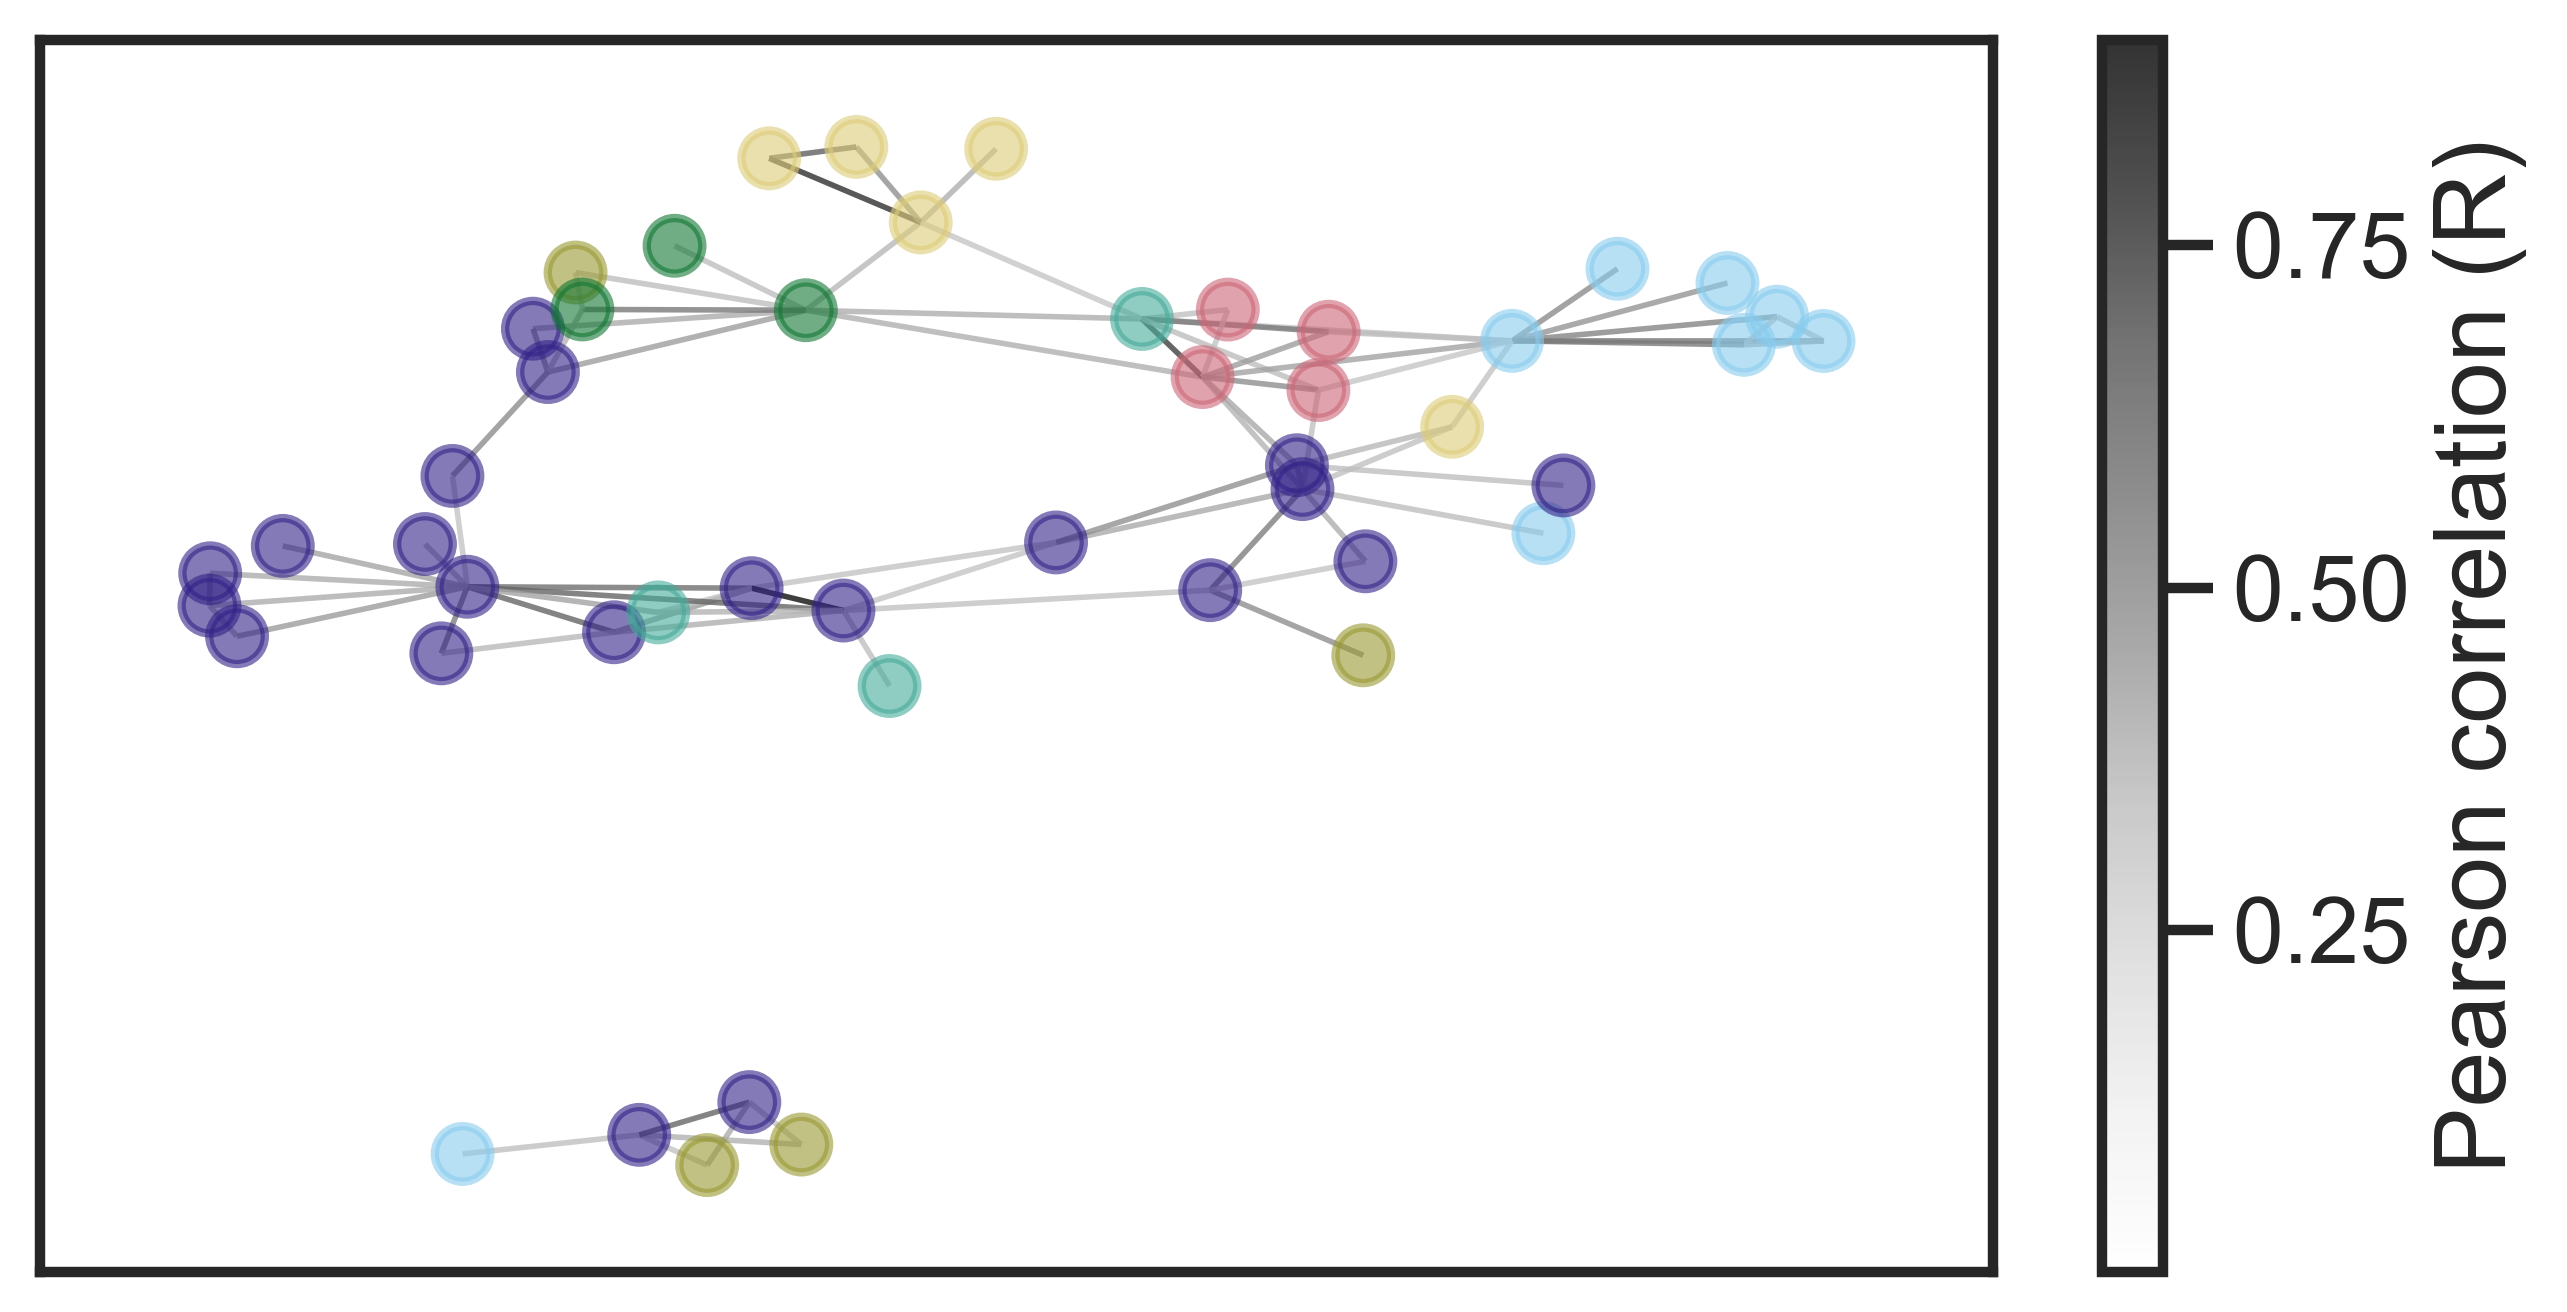

In [18]:
corr_filt = coabundance_df.loc[(coabundance_df['cell_line']=='A498') &
                               (coabundance_df['corr']>= 0.3)]

corr_colors = {'nodes': {}, 'edges': {}, 'width': {}}

for index, row in corr_filt.iterrows():
    if row['col1'] not in corr_colors['nodes']: 
        corr_colors['nodes'][row['col1']] = utils.get_color_by_class(metabolite_ID.loc[metabolite_ID.ion==row['col1'],
                                                                     'class'].values[0])
    if row['col2'] not in corr_colors['nodes']: 
        corr_colors['nodes'][row['col2']] = utils.get_color_by_class(metabolite_ID.loc[metabolite_ID.ion==row['col2'],
                                                                     'class'].values[0])
    edge = tuple(sorted([row['col1'], row['col2']]))
    if edge not in corr_colors['edges']:
        corr_colors['edges'][edge] = row['corr']

plt.figure(figsize=(7, 4))
G = nx.from_pandas_edgelist(corr_filt, source='col1', target='col2')
nodes_color = [corr_colors['nodes'][n] for n in list(G.nodes)]
edges_color = [corr_colors['edges'][tuple(sorted(n))] for n in list(G.edges)]
pos = nx.spring_layout(G, seed = 1)
ec = nx.draw_networkx_edges(G, pos, alpha=0.8, edge_cmap=plt.cm.get_cmap('Greys'), edge_color=edges_color, edge_vmin=0, edge_vmax=0.9)
nc = nx.draw_networkx_nodes(G, pos, alpha=0.6, node_size=100, node_color=nodes_color)
plt.colorbar(ec, fraction=0.05, aspect=20, shrink=1, ticks=[0.25,0.5,0.75,1.0], label='Pearson correlation (R)')

plt.savefig(plots_path / 'panel_D_A498.png', bbox_inches='tight')
plt.savefig(plots_path / 'panel_D_A498.svg', bbox_inches='tight')

#### BT-549

/var/folders/yd/30x9k4ks4xgcqd7x9_jk19c40000gn/T/ipykernel_60115/1220815708.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ec = nx.draw_networkx_edges(G, pos, alpha=0.8, edge_cmap=plt.cm.get_cmap('Greys'), edge_color=edges_color, edge_vmin=0, edge_vmax=0.9)


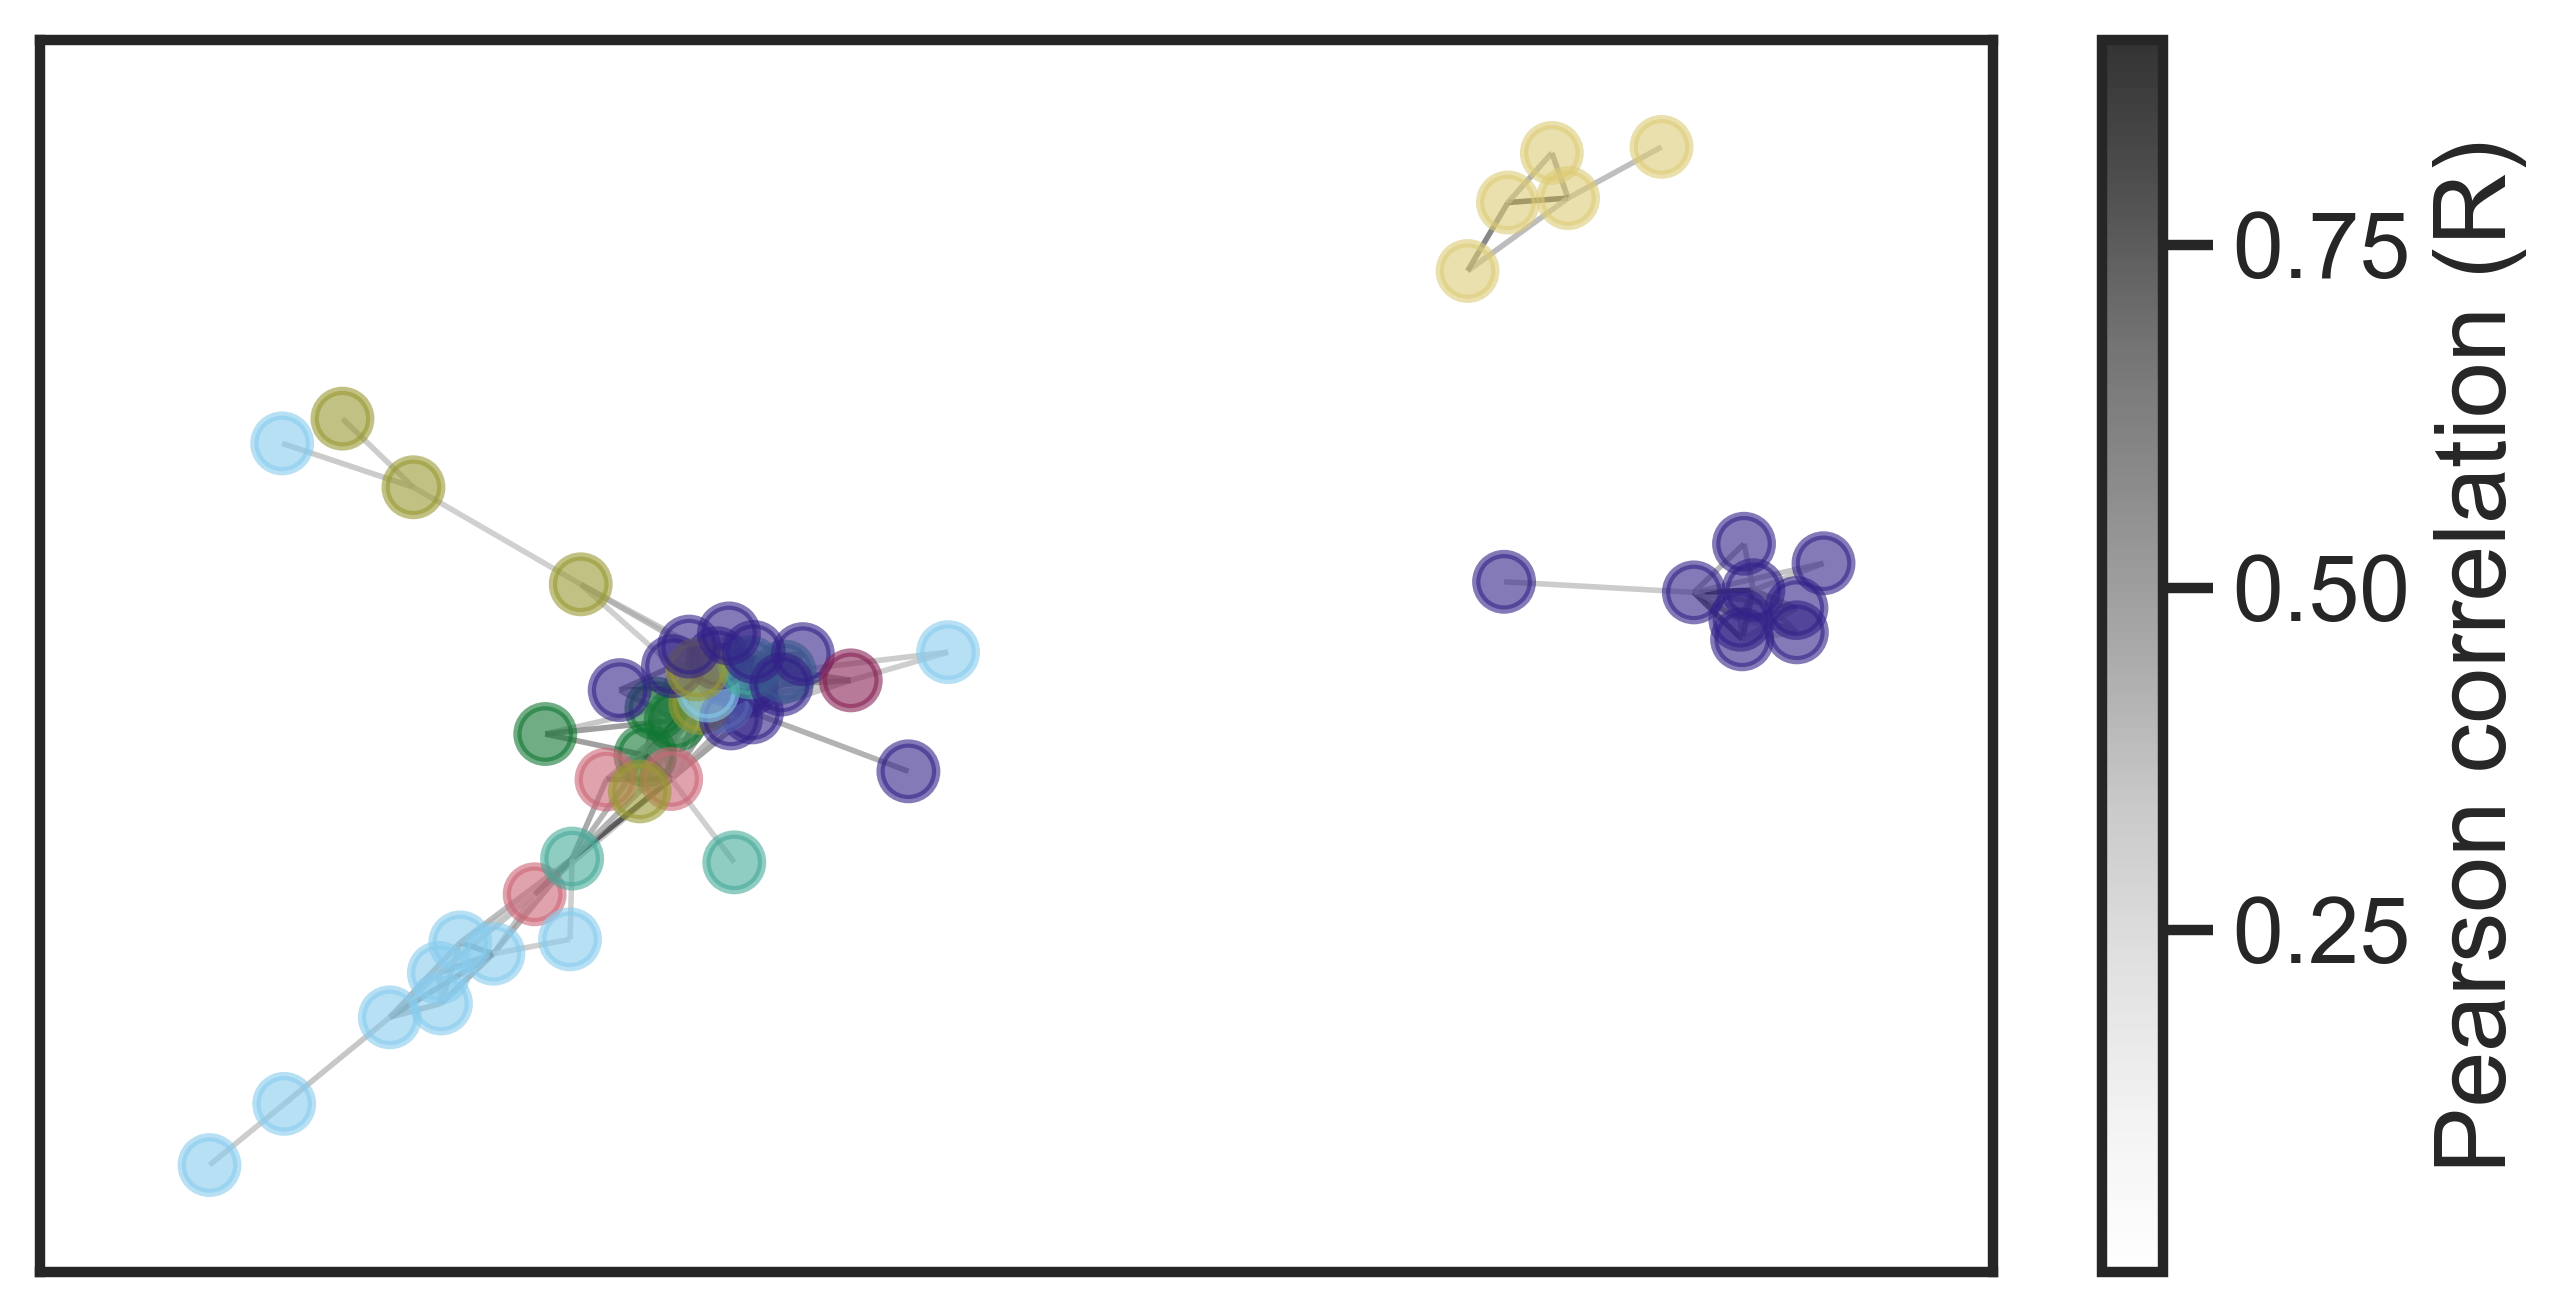

In [19]:
corr_filt = coabundance_df.loc[(coabundance_df['cell_line']=='BT-549') &
                               (coabundance_df['corr']>= 0.3)]

corr_colors = {'nodes': {}, 'edges': {}, 'width': {}}

for index, row in corr_filt.iterrows():
    if row['col1'] not in corr_colors['nodes']: 
        corr_colors['nodes'][row['col1']] = utils.get_color_by_class(metabolite_ID.loc[metabolite_ID.ion==row['col1'],
                                                                     'class'].values[0])
    if row['col2'] not in corr_colors['nodes']: 
        corr_colors['nodes'][row['col2']] = utils.get_color_by_class(metabolite_ID.loc[metabolite_ID.ion==row['col2'],
                                                                     'class'].values[0])
    edge = tuple(sorted([row['col1'], row['col2']]))
    if edge not in corr_colors['edges']:
        corr_colors['edges'][edge] = row['corr']

plt.figure(figsize=(7, 4))
G = nx.from_pandas_edgelist(corr_filt, source='col1', target='col2')
nodes_color = [corr_colors['nodes'][n] for n in list(G.nodes)]
edges_color = [corr_colors['edges'][tuple(sorted(n))] for n in list(G.edges)]
pos = nx.spring_layout(G, seed = 1)
ec = nx.draw_networkx_edges(G, pos, alpha=0.8, edge_cmap=plt.cm.get_cmap('Greys'), edge_color=edges_color, edge_vmin=0, edge_vmax=0.9)
nc = nx.draw_networkx_nodes(G, pos, alpha=0.6, node_size=100, node_color=nodes_color)
plt.colorbar(ec, fraction=0.05, aspect=20, shrink=1, ticks=[0.25,0.5,0.75,1.0], label='Pearson correlation (R)')

plt.savefig(plots_path / 'panel_D_BT-549.png', bbox_inches='tight')
plt.savefig(plots_path / 'panel_D_BT-549.svg', bbox_inches='tight')

#### HOP-62

/var/folders/yd/30x9k4ks4xgcqd7x9_jk19c40000gn/T/ipykernel_60115/185607093.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ec = nx.draw_networkx_edges(G, pos, alpha=0.8, edge_cmap=plt.cm.get_cmap('Greys'), edge_color=edges_color, edge_vmin=0, edge_vmax=0.9)


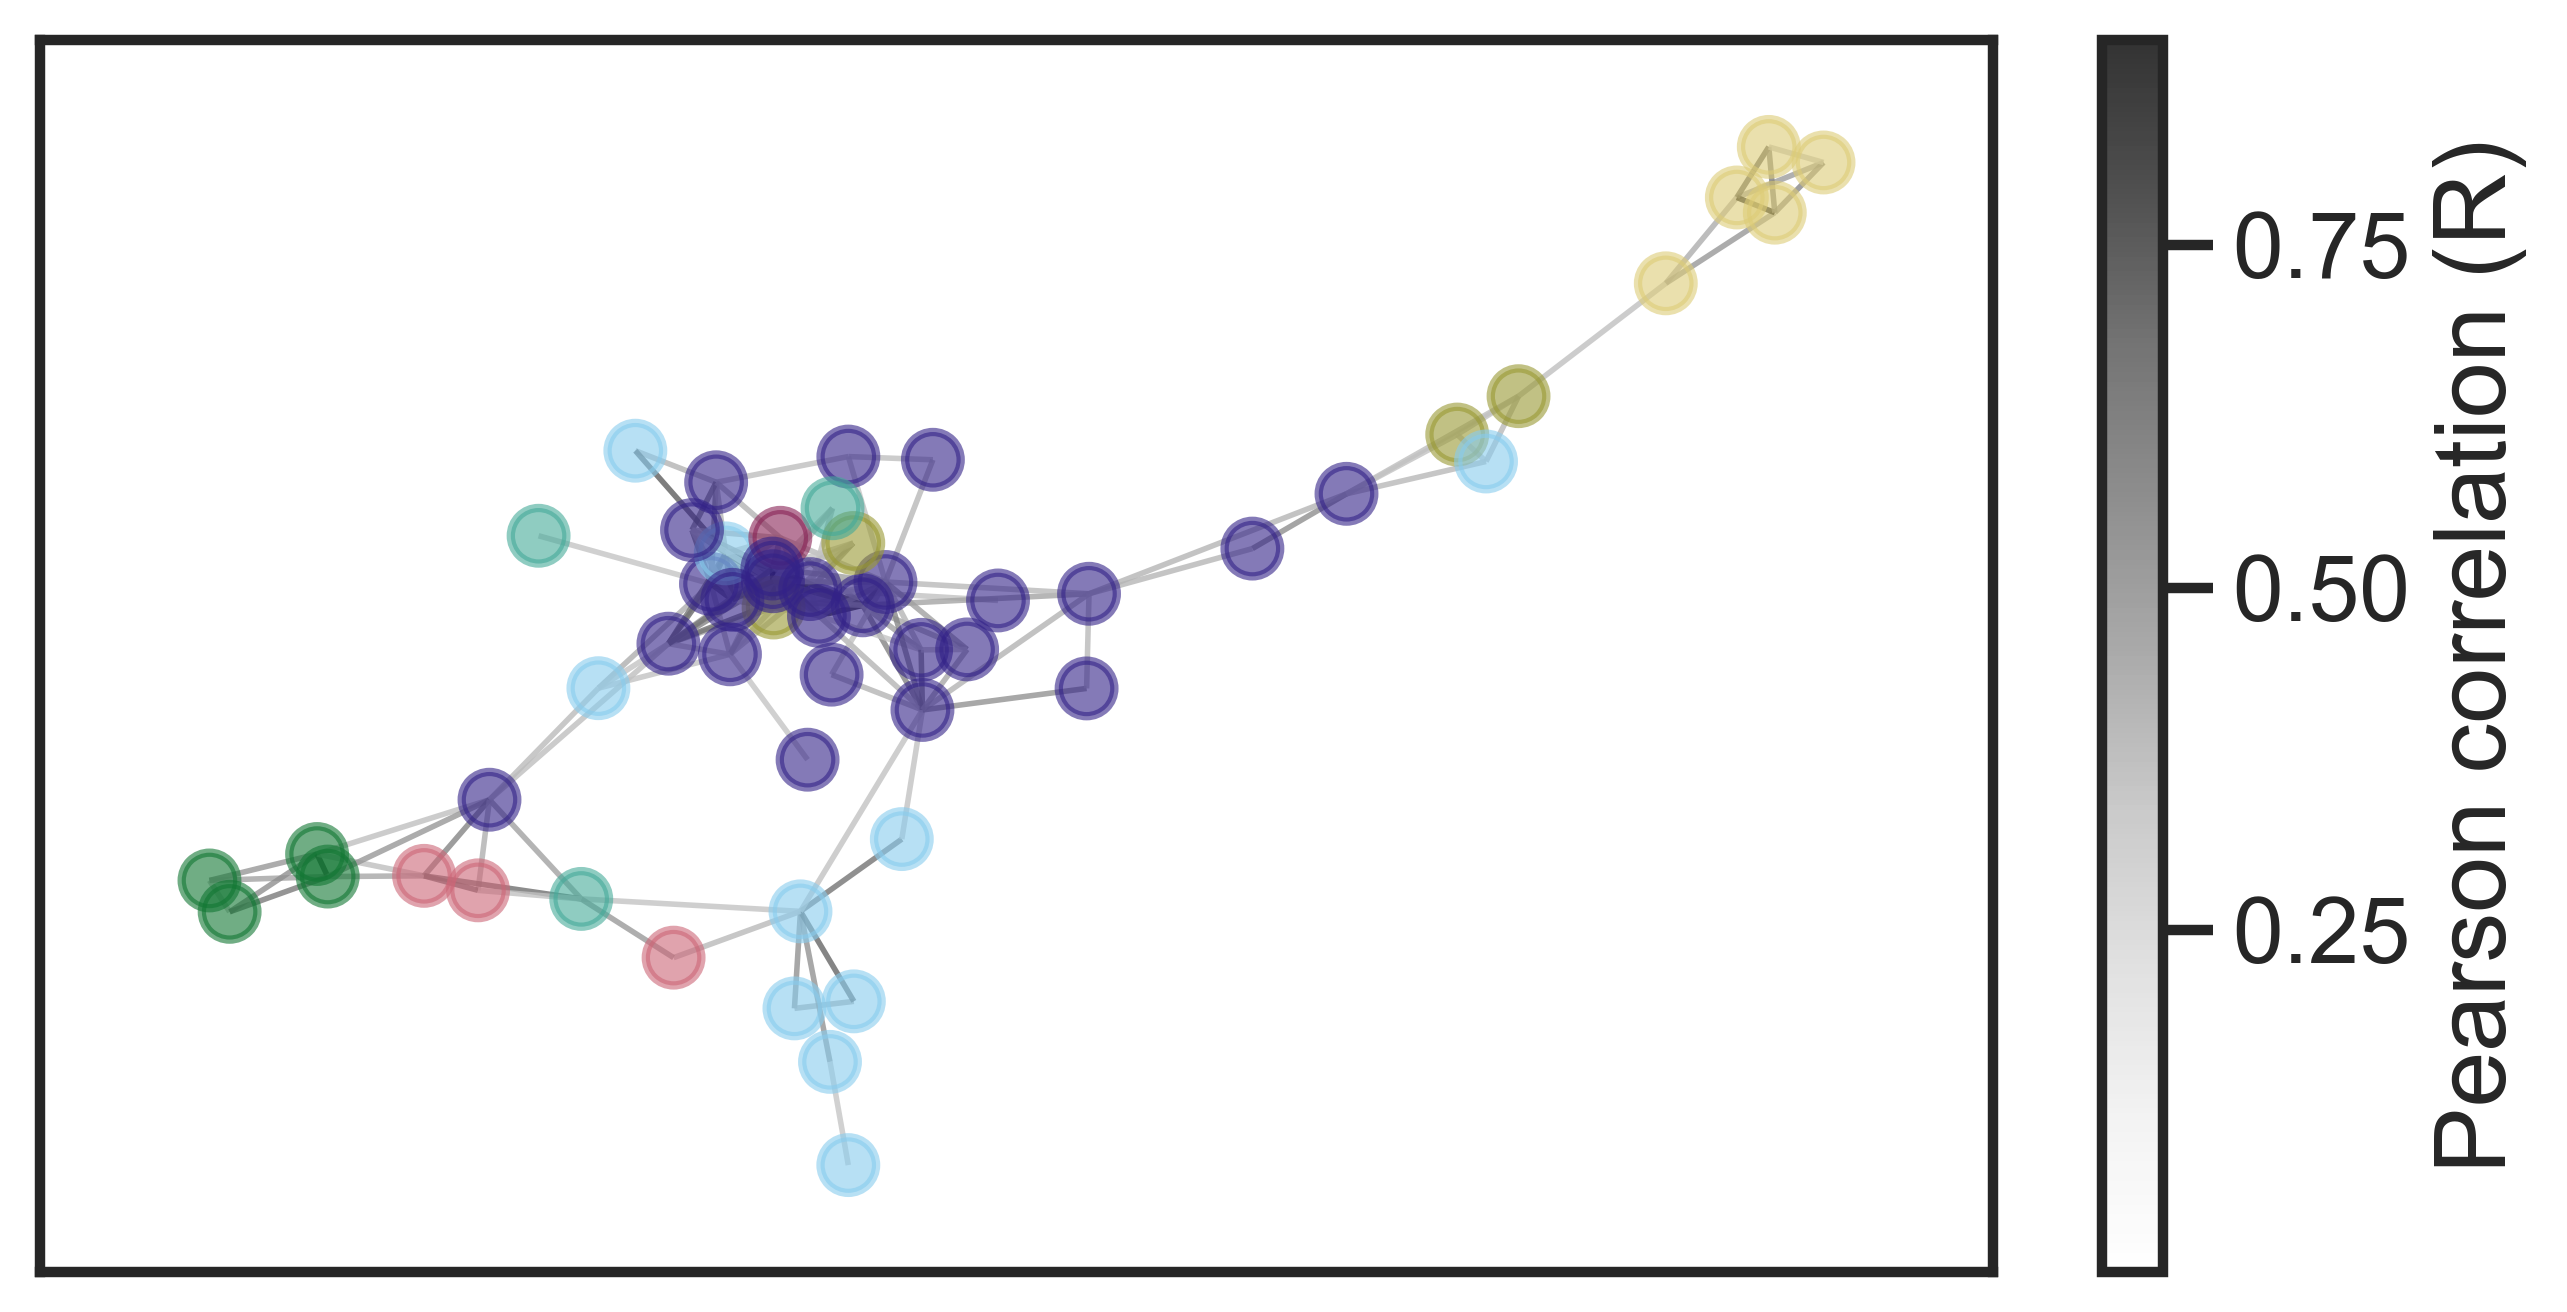

In [20]:
corr_filt = coabundance_df.loc[(coabundance_df['cell_line']=='HOP-62') &
                               (coabundance_df['corr']>= 0.3)]

corr_colors = {'nodes': {}, 'edges': {}, 'width': {}}

for index, row in corr_filt.iterrows():
    if row['col1'] not in corr_colors['nodes']: 
        corr_colors['nodes'][row['col1']] = utils.get_color_by_class(metabolite_ID.loc[metabolite_ID.ion==row['col1'],
                                                                     'class'].values[0])
    if row['col2'] not in corr_colors['nodes']: 
        corr_colors['nodes'][row['col2']] = utils.get_color_by_class(metabolite_ID.loc[metabolite_ID.ion==row['col2'],
                                                                     'class'].values[0])
    edge = tuple(sorted([row['col1'], row['col2']]))
    if edge not in corr_colors['edges']:
        corr_colors['edges'][edge] = row['corr']

plt.figure(figsize=(7, 4))
G = nx.from_pandas_edgelist(corr_filt, source='col1', target='col2')
nodes_color = [corr_colors['nodes'][n] for n in list(G.nodes)]
edges_color = [corr_colors['edges'][tuple(sorted(n))] for n in list(G.edges)]
pos = nx.spring_layout(G, seed = 1)
ec = nx.draw_networkx_edges(G, pos, alpha=0.8, edge_cmap=plt.cm.get_cmap('Greys'), edge_color=edges_color, edge_vmin=0, edge_vmax=0.9)
nc = nx.draw_networkx_nodes(G, pos, alpha=0.6, node_size=100, node_color=nodes_color)
plt.colorbar(ec, fraction=0.05, aspect=20, shrink=1, ticks=[0.25,0.5,0.75,1.0], label='Pearson correlation (R)')

plt.savefig(plots_path / 'panel_D_HOP-62.png', bbox_inches='tight')
plt.savefig(plots_path / 'panel_D_HOP-62.svg', bbox_inches='tight')

#### HS 578T

/var/folders/yd/30x9k4ks4xgcqd7x9_jk19c40000gn/T/ipykernel_60115/3479843960.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ec = nx.draw_networkx_edges(G, pos, alpha=0.8, edge_cmap=plt.cm.get_cmap('Greys'), edge_color=edges_color, edge_vmin=0, edge_vmax=0.9)


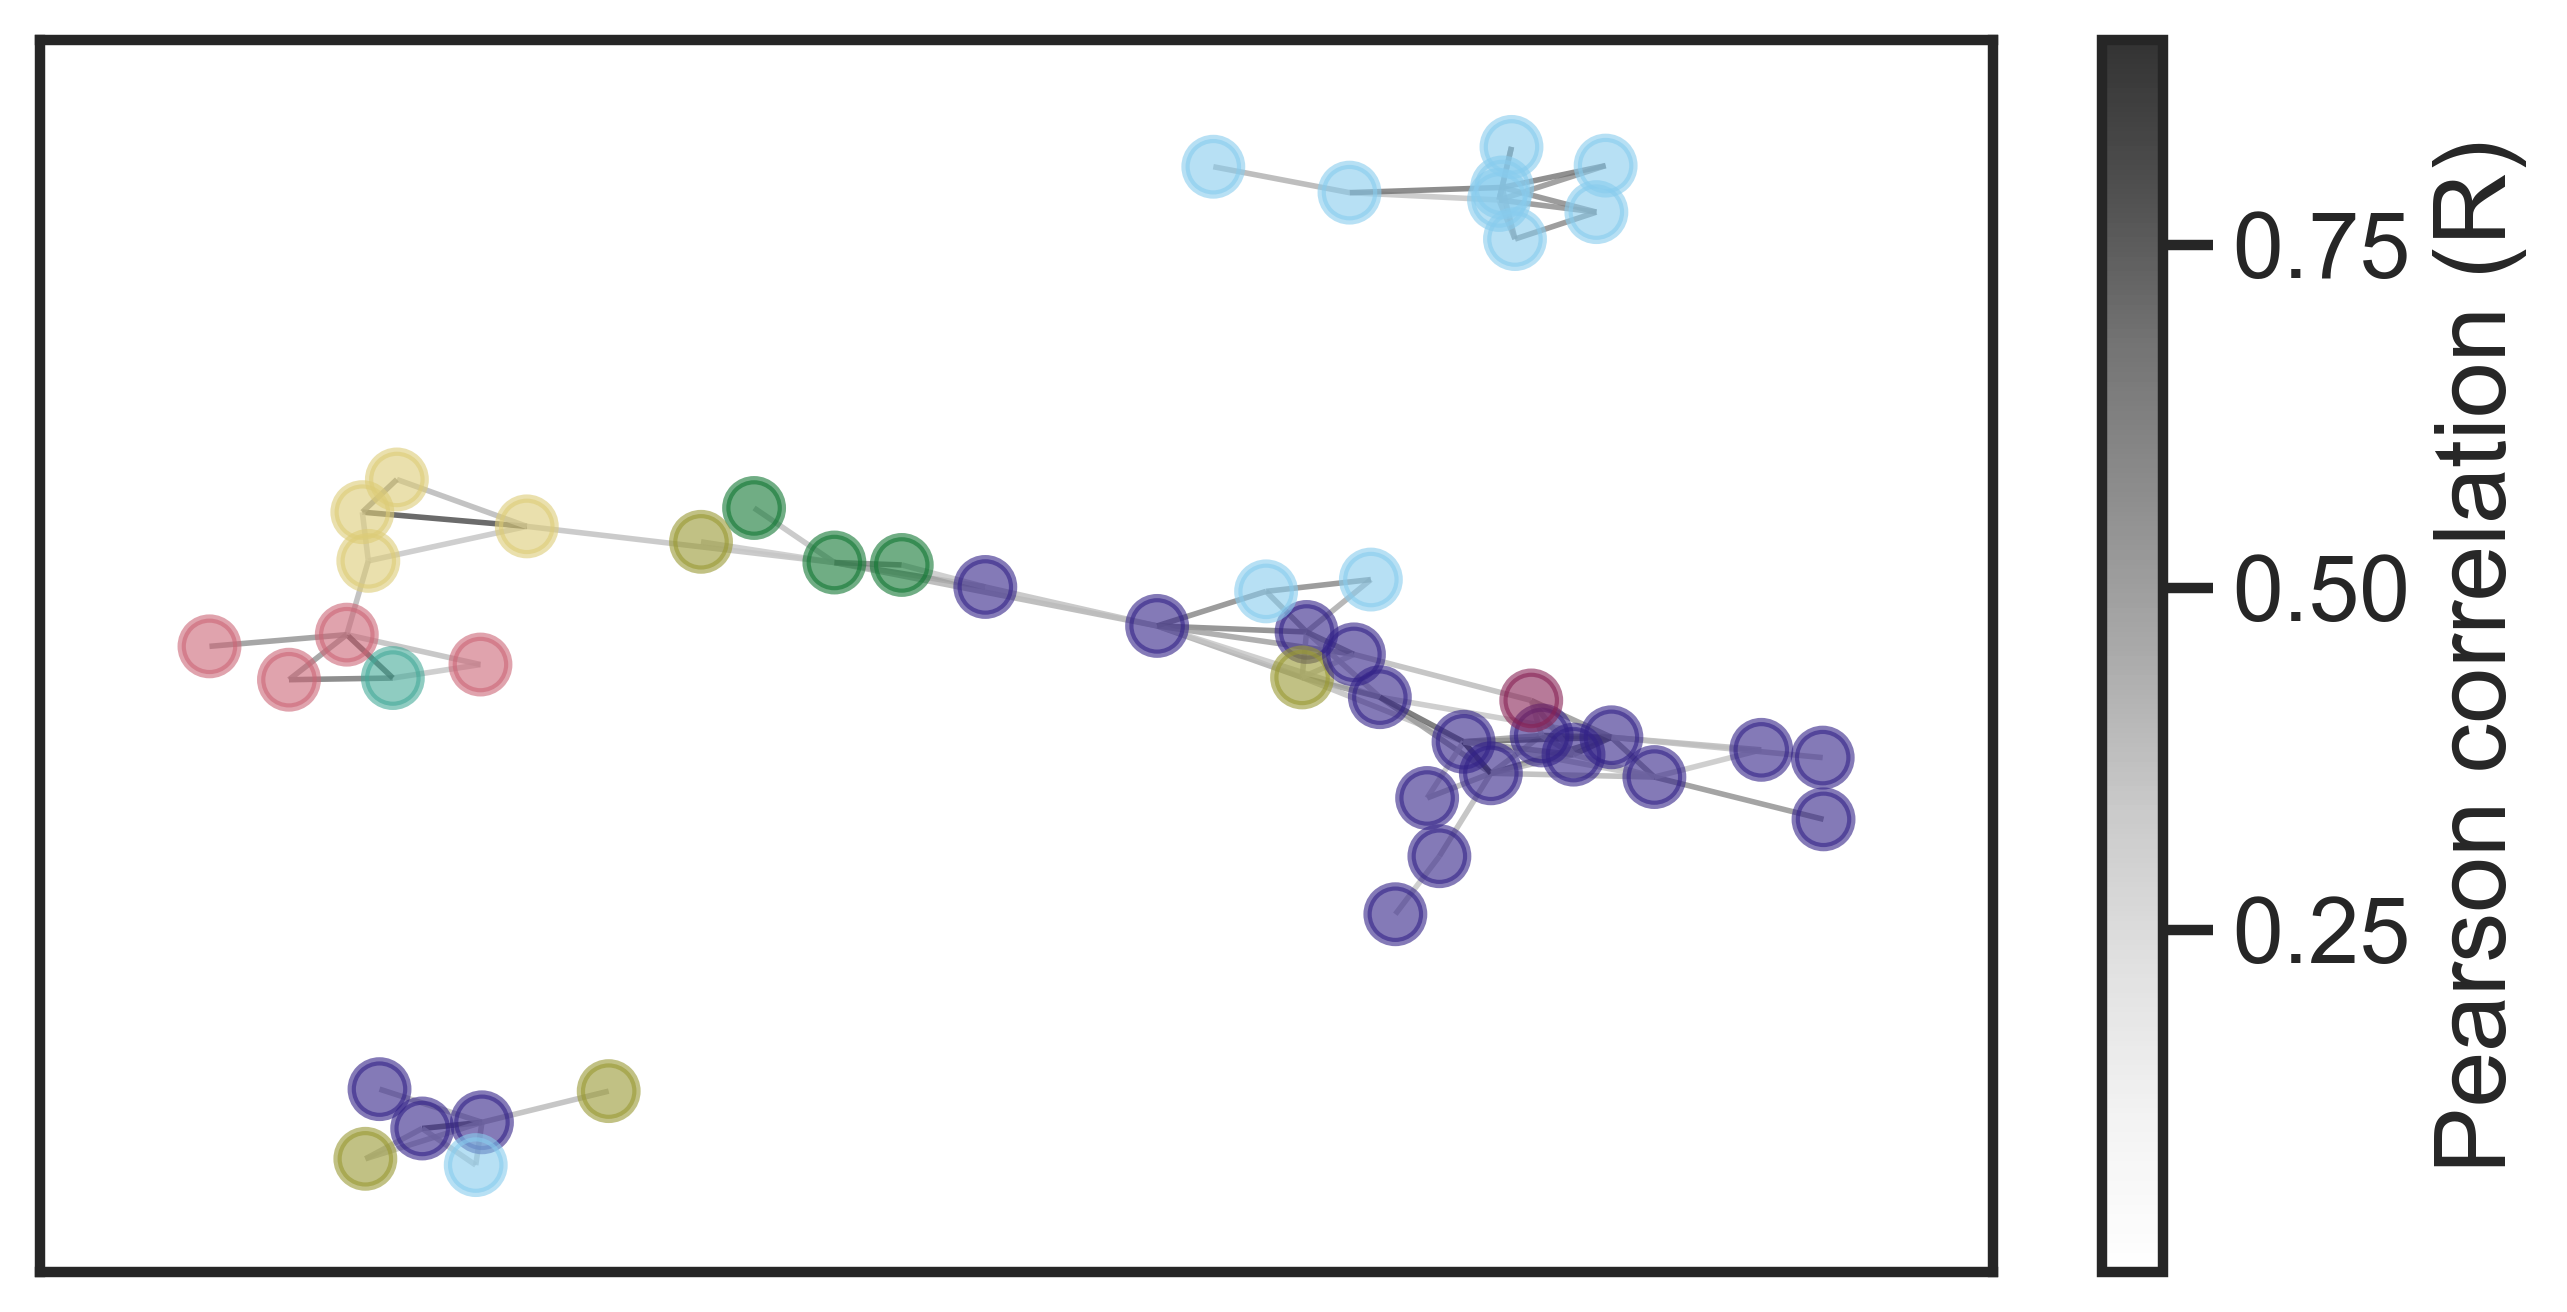

In [21]:
corr_filt = coabundance_df.loc[(coabundance_df['cell_line']=='HS 578T') &
                               (coabundance_df['corr']>= 0.3)]

corr_colors = {'nodes': {}, 'edges': {}, 'width': {}}

for index, row in corr_filt.iterrows():
    if row['col1'] not in corr_colors['nodes']: 
        corr_colors['nodes'][row['col1']] = utils.get_color_by_class(metabolite_ID.loc[metabolite_ID.ion==row['col1'],
                                                                     'class'].values[0])
    if row['col2'] not in corr_colors['nodes']: 
        corr_colors['nodes'][row['col2']] = utils.get_color_by_class(metabolite_ID.loc[metabolite_ID.ion==row['col2'],
                                                                     'class'].values[0])
    edge = tuple(sorted([row['col1'], row['col2']]))
    if edge not in corr_colors['edges']:
        corr_colors['edges'][edge] = row['corr']

plt.figure(figsize=(7, 4))
G = nx.from_pandas_edgelist(corr_filt, source='col1', target='col2')
nodes_color = [corr_colors['nodes'][n] for n in list(G.nodes)]
edges_color = [corr_colors['edges'][tuple(sorted(n))] for n in list(G.edges)]
pos = nx.spring_layout(G, seed = 1)
ec = nx.draw_networkx_edges(G, pos, alpha=0.8, edge_cmap=plt.cm.get_cmap('Greys'), edge_color=edges_color, edge_vmin=0, edge_vmax=0.9)
nc = nx.draw_networkx_nodes(G, pos, alpha=0.6, node_size=100, node_color=nodes_color)
plt.colorbar(ec, fraction=0.05, aspect=20, shrink=1, ticks=[0.25,0.5,0.75,1.0], label='Pearson correlation (R)')

plt.savefig(plots_path / 'panel_D_HS 578T.png', bbox_inches='tight')
plt.savefig(plots_path / 'panel_D_HS 578T.svg', bbox_inches='tight')

#### HT29

/var/folders/yd/30x9k4ks4xgcqd7x9_jk19c40000gn/T/ipykernel_60115/3211620788.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ec = nx.draw_networkx_edges(G, pos, alpha=0.8, edge_cmap=plt.cm.get_cmap('Greys'), edge_color=edges_color, edge_vmin=0, edge_vmax=0.9)


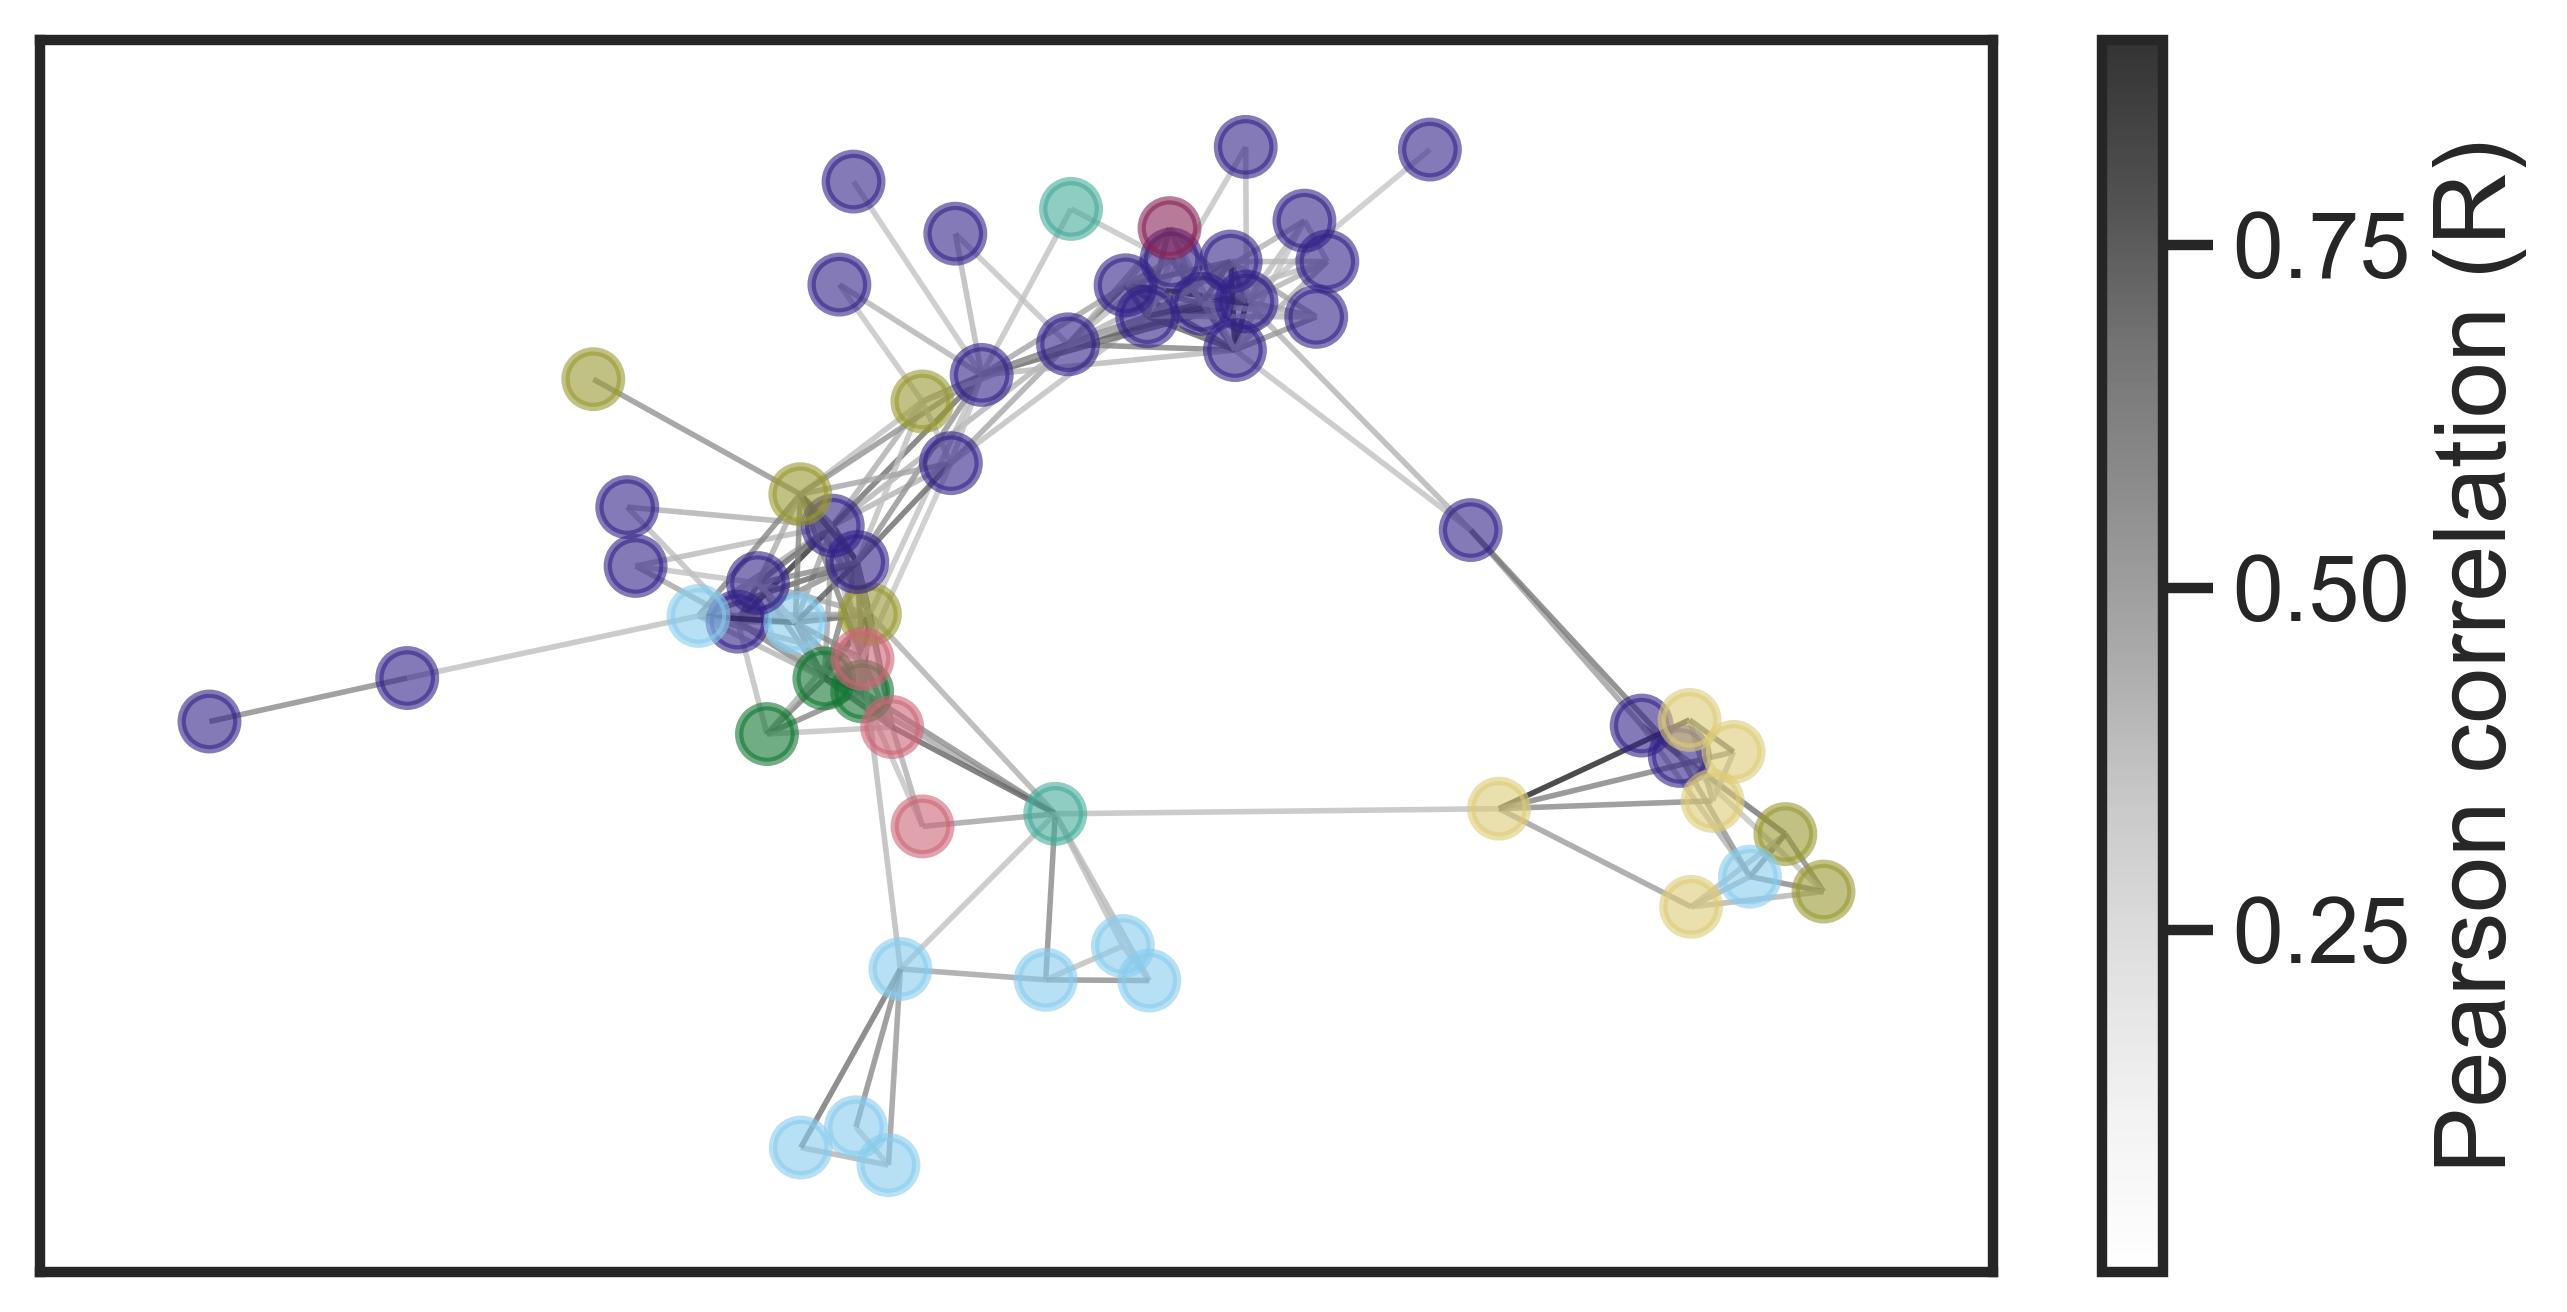

In [22]:
corr_filt = coabundance_df.loc[(coabundance_df['cell_line']=='HT29') &
                               (coabundance_df['corr']>= 0.3)]

corr_colors = {'nodes': {}, 'edges': {}, 'width': {}}

for index, row in corr_filt.iterrows():
    if row['col1'] not in corr_colors['nodes']: 
        corr_colors['nodes'][row['col1']] = utils.get_color_by_class(metabolite_ID.loc[metabolite_ID.ion==row['col1'],
                                                                     'class'].values[0])
    if row['col2'] not in corr_colors['nodes']: 
        corr_colors['nodes'][row['col2']] = utils.get_color_by_class(metabolite_ID.loc[metabolite_ID.ion==row['col2'],
                                                                     'class'].values[0])
    edge = tuple(sorted([row['col1'], row['col2']]))
    if edge not in corr_colors['edges']:
        corr_colors['edges'][edge] = row['corr']

plt.figure(figsize=(7, 4))
G = nx.from_pandas_edgelist(corr_filt, source='col1', target='col2')
nodes_color = [corr_colors['nodes'][n] for n in list(G.nodes)]
edges_color = [corr_colors['edges'][tuple(sorted(n))] for n in list(G.edges)]
pos = nx.spring_layout(G, seed = 1)
ec = nx.draw_networkx_edges(G, pos, alpha=0.8, edge_cmap=plt.cm.get_cmap('Greys'), edge_color=edges_color, edge_vmin=0, edge_vmax=0.9)
nc = nx.draw_networkx_nodes(G, pos, alpha=0.6, node_size=100, node_color=nodes_color)
plt.colorbar(ec, fraction=0.05, aspect=20, shrink=1, ticks=[0.25,0.5,0.75,1.0], label='Pearson correlation (R)')

plt.savefig(plots_path / 'panel_D_HT29.png', bbox_inches='tight')
plt.savefig(plots_path / 'panel_D_HT29.svg', bbox_inches='tight')

#### HeLa

/var/folders/yd/30x9k4ks4xgcqd7x9_jk19c40000gn/T/ipykernel_60115/4168487338.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ec = nx.draw_networkx_edges(G, pos, alpha=0.8, edge_cmap=plt.cm.get_cmap('Greys'), edge_color=edges_color, edge_vmin=0, edge_vmax=0.9)


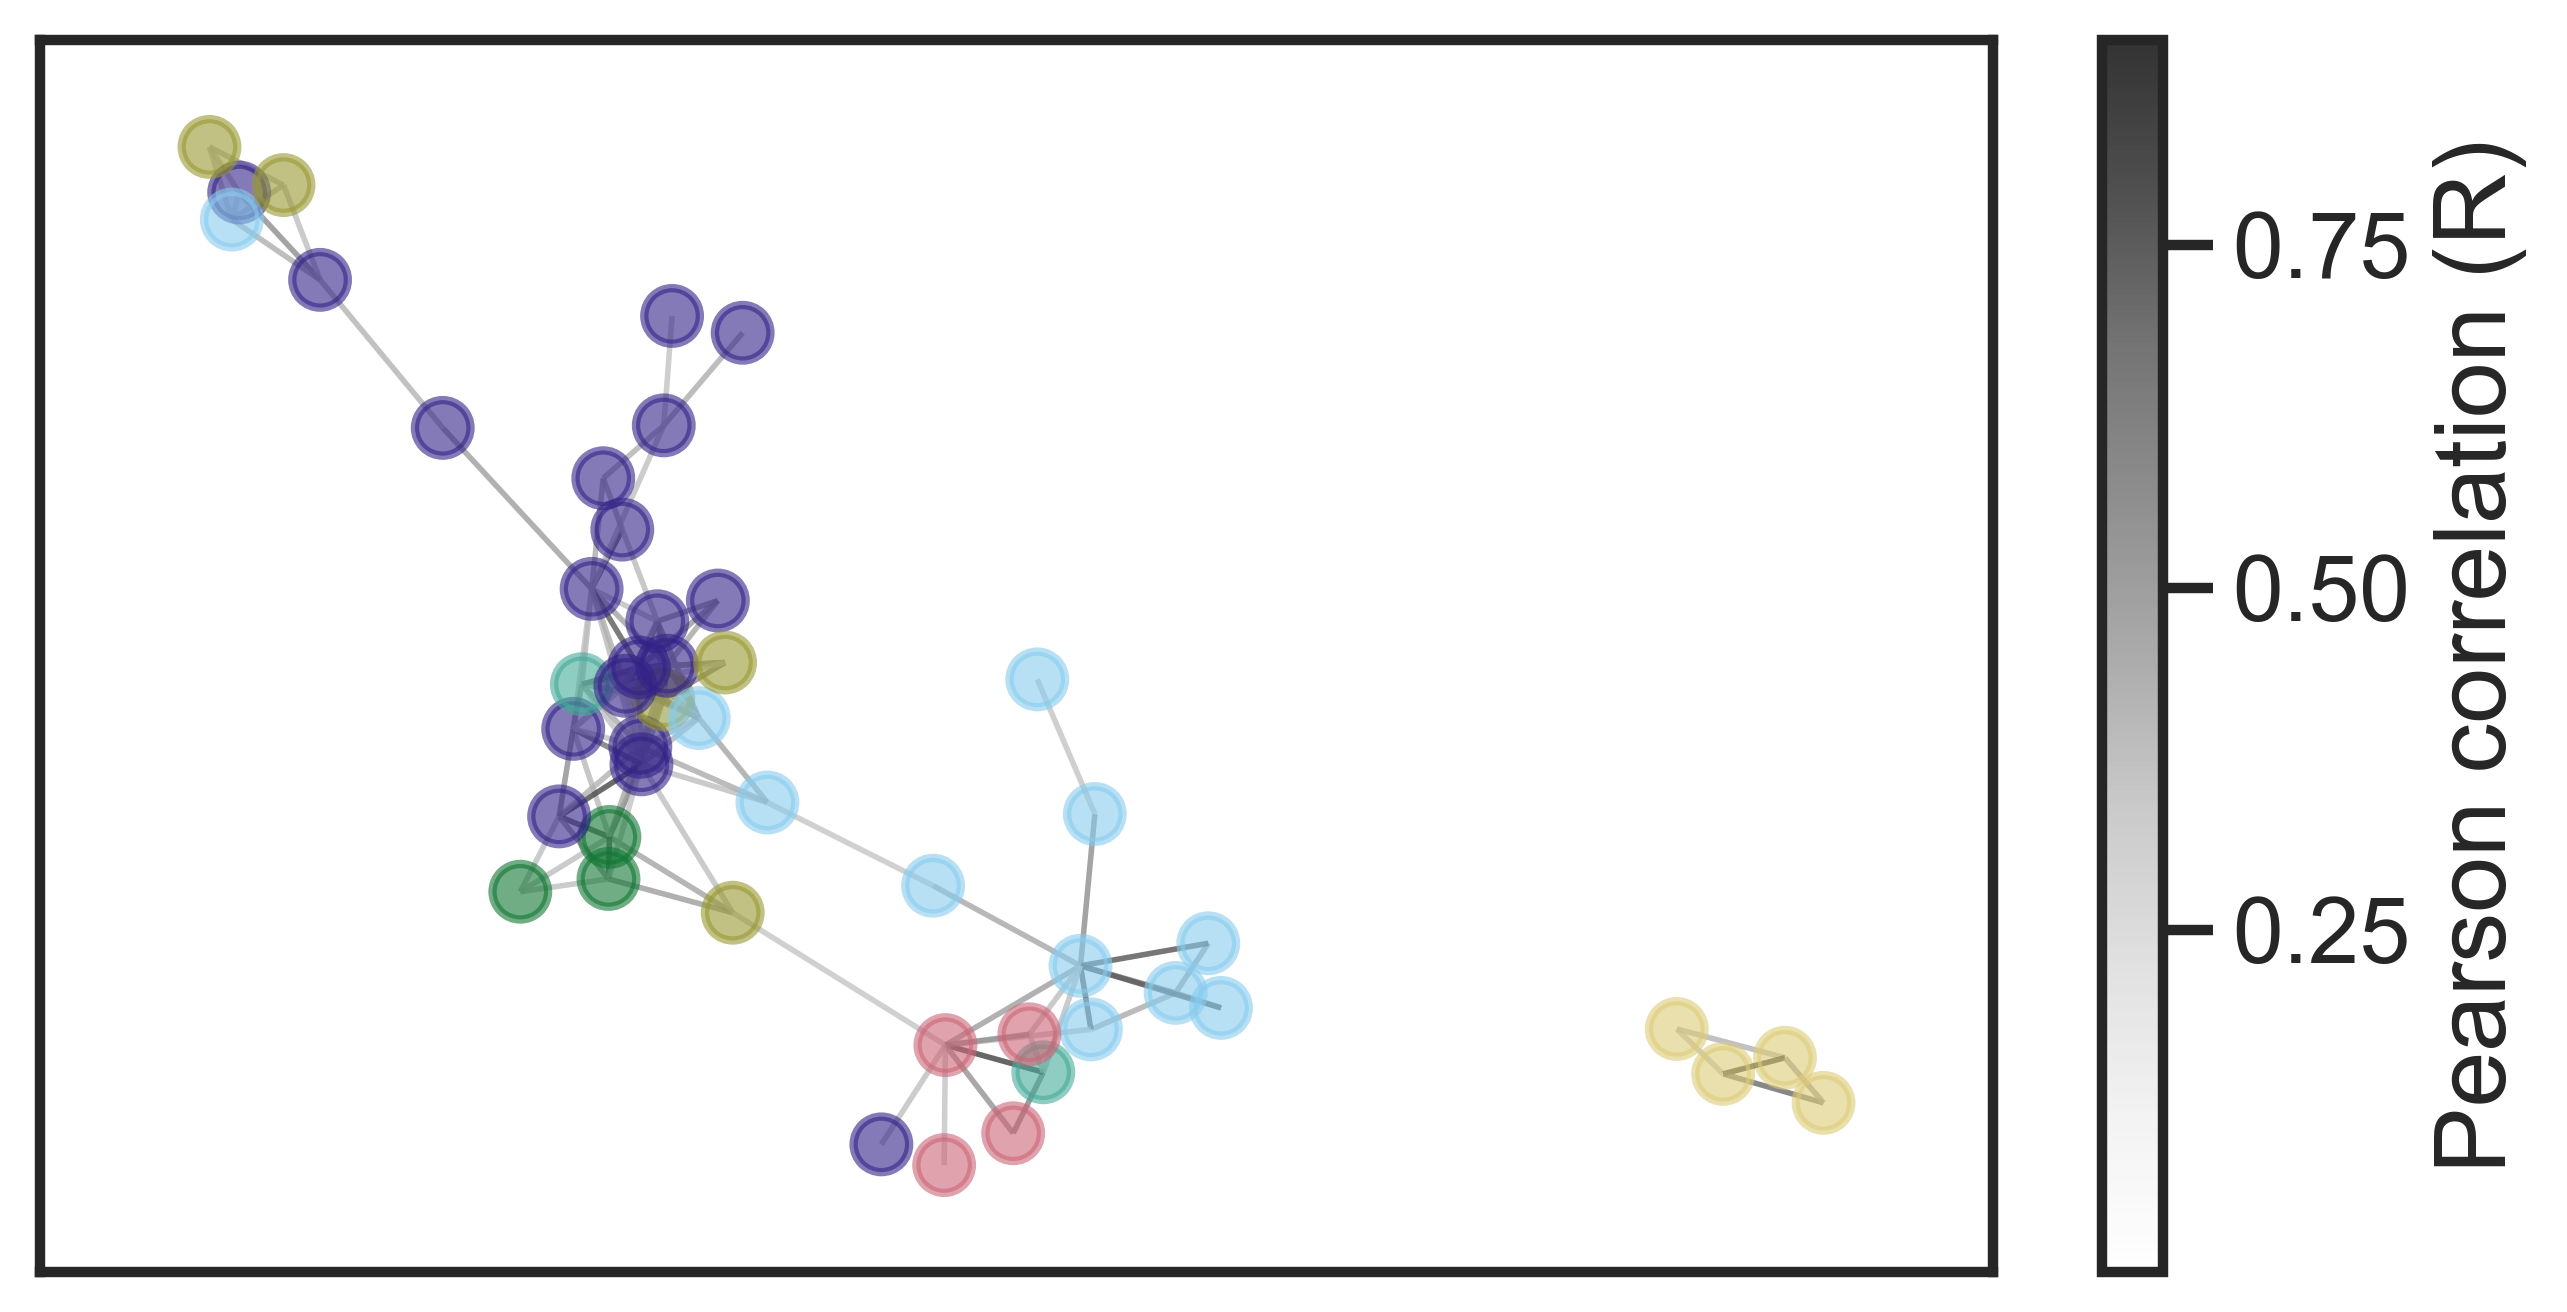

In [23]:
corr_filt = coabundance_df.loc[(coabundance_df['cell_line']=='HeLa') &
                               (coabundance_df['corr']>= 0.3)]

corr_colors = {'nodes': {}, 'edges': {}, 'width': {}}

for index, row in corr_filt.iterrows():
    if row['col1'] not in corr_colors['nodes']: 
        corr_colors['nodes'][row['col1']] = utils.get_color_by_class(metabolite_ID.loc[metabolite_ID.ion==row['col1'],
                                                                     'class'].values[0])
    if row['col2'] not in corr_colors['nodes']: 
        corr_colors['nodes'][row['col2']] = utils.get_color_by_class(metabolite_ID.loc[metabolite_ID.ion==row['col2'],
                                                                     'class'].values[0])
    edge = tuple(sorted([row['col1'], row['col2']]))
    if edge not in corr_colors['edges']:
        corr_colors['edges'][edge] = row['corr']

plt.figure(figsize=(7, 4))
G = nx.from_pandas_edgelist(corr_filt, source='col1', target='col2')
nodes_color = [corr_colors['nodes'][n] for n in list(G.nodes)]
edges_color = [corr_colors['edges'][tuple(sorted(n))] for n in list(G.edges)]
pos = nx.spring_layout(G, seed = 1)
ec = nx.draw_networkx_edges(G, pos, alpha=0.8, edge_cmap=plt.cm.get_cmap('Greys'), edge_color=edges_color, edge_vmin=0, edge_vmax=0.9)
nc = nx.draw_networkx_nodes(G, pos, alpha=0.6, node_size=100, node_color=nodes_color)
plt.colorbar(ec, fraction=0.05, aspect=20, shrink=1, ticks=[0.25,0.5,0.75,1.0], label='Pearson correlation (R)')

plt.savefig(plots_path / 'panel_D_HeLa.png', bbox_inches='tight')
plt.savefig(plots_path / 'panel_D_HeLa.svg', bbox_inches='tight')

#### IGR-OV1

/var/folders/yd/30x9k4ks4xgcqd7x9_jk19c40000gn/T/ipykernel_60115/438449038.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ec = nx.draw_networkx_edges(G, pos, alpha=0.8, edge_cmap=plt.cm.get_cmap('Greys'), edge_color=edges_color, edge_vmin=0, edge_vmax=0.9)


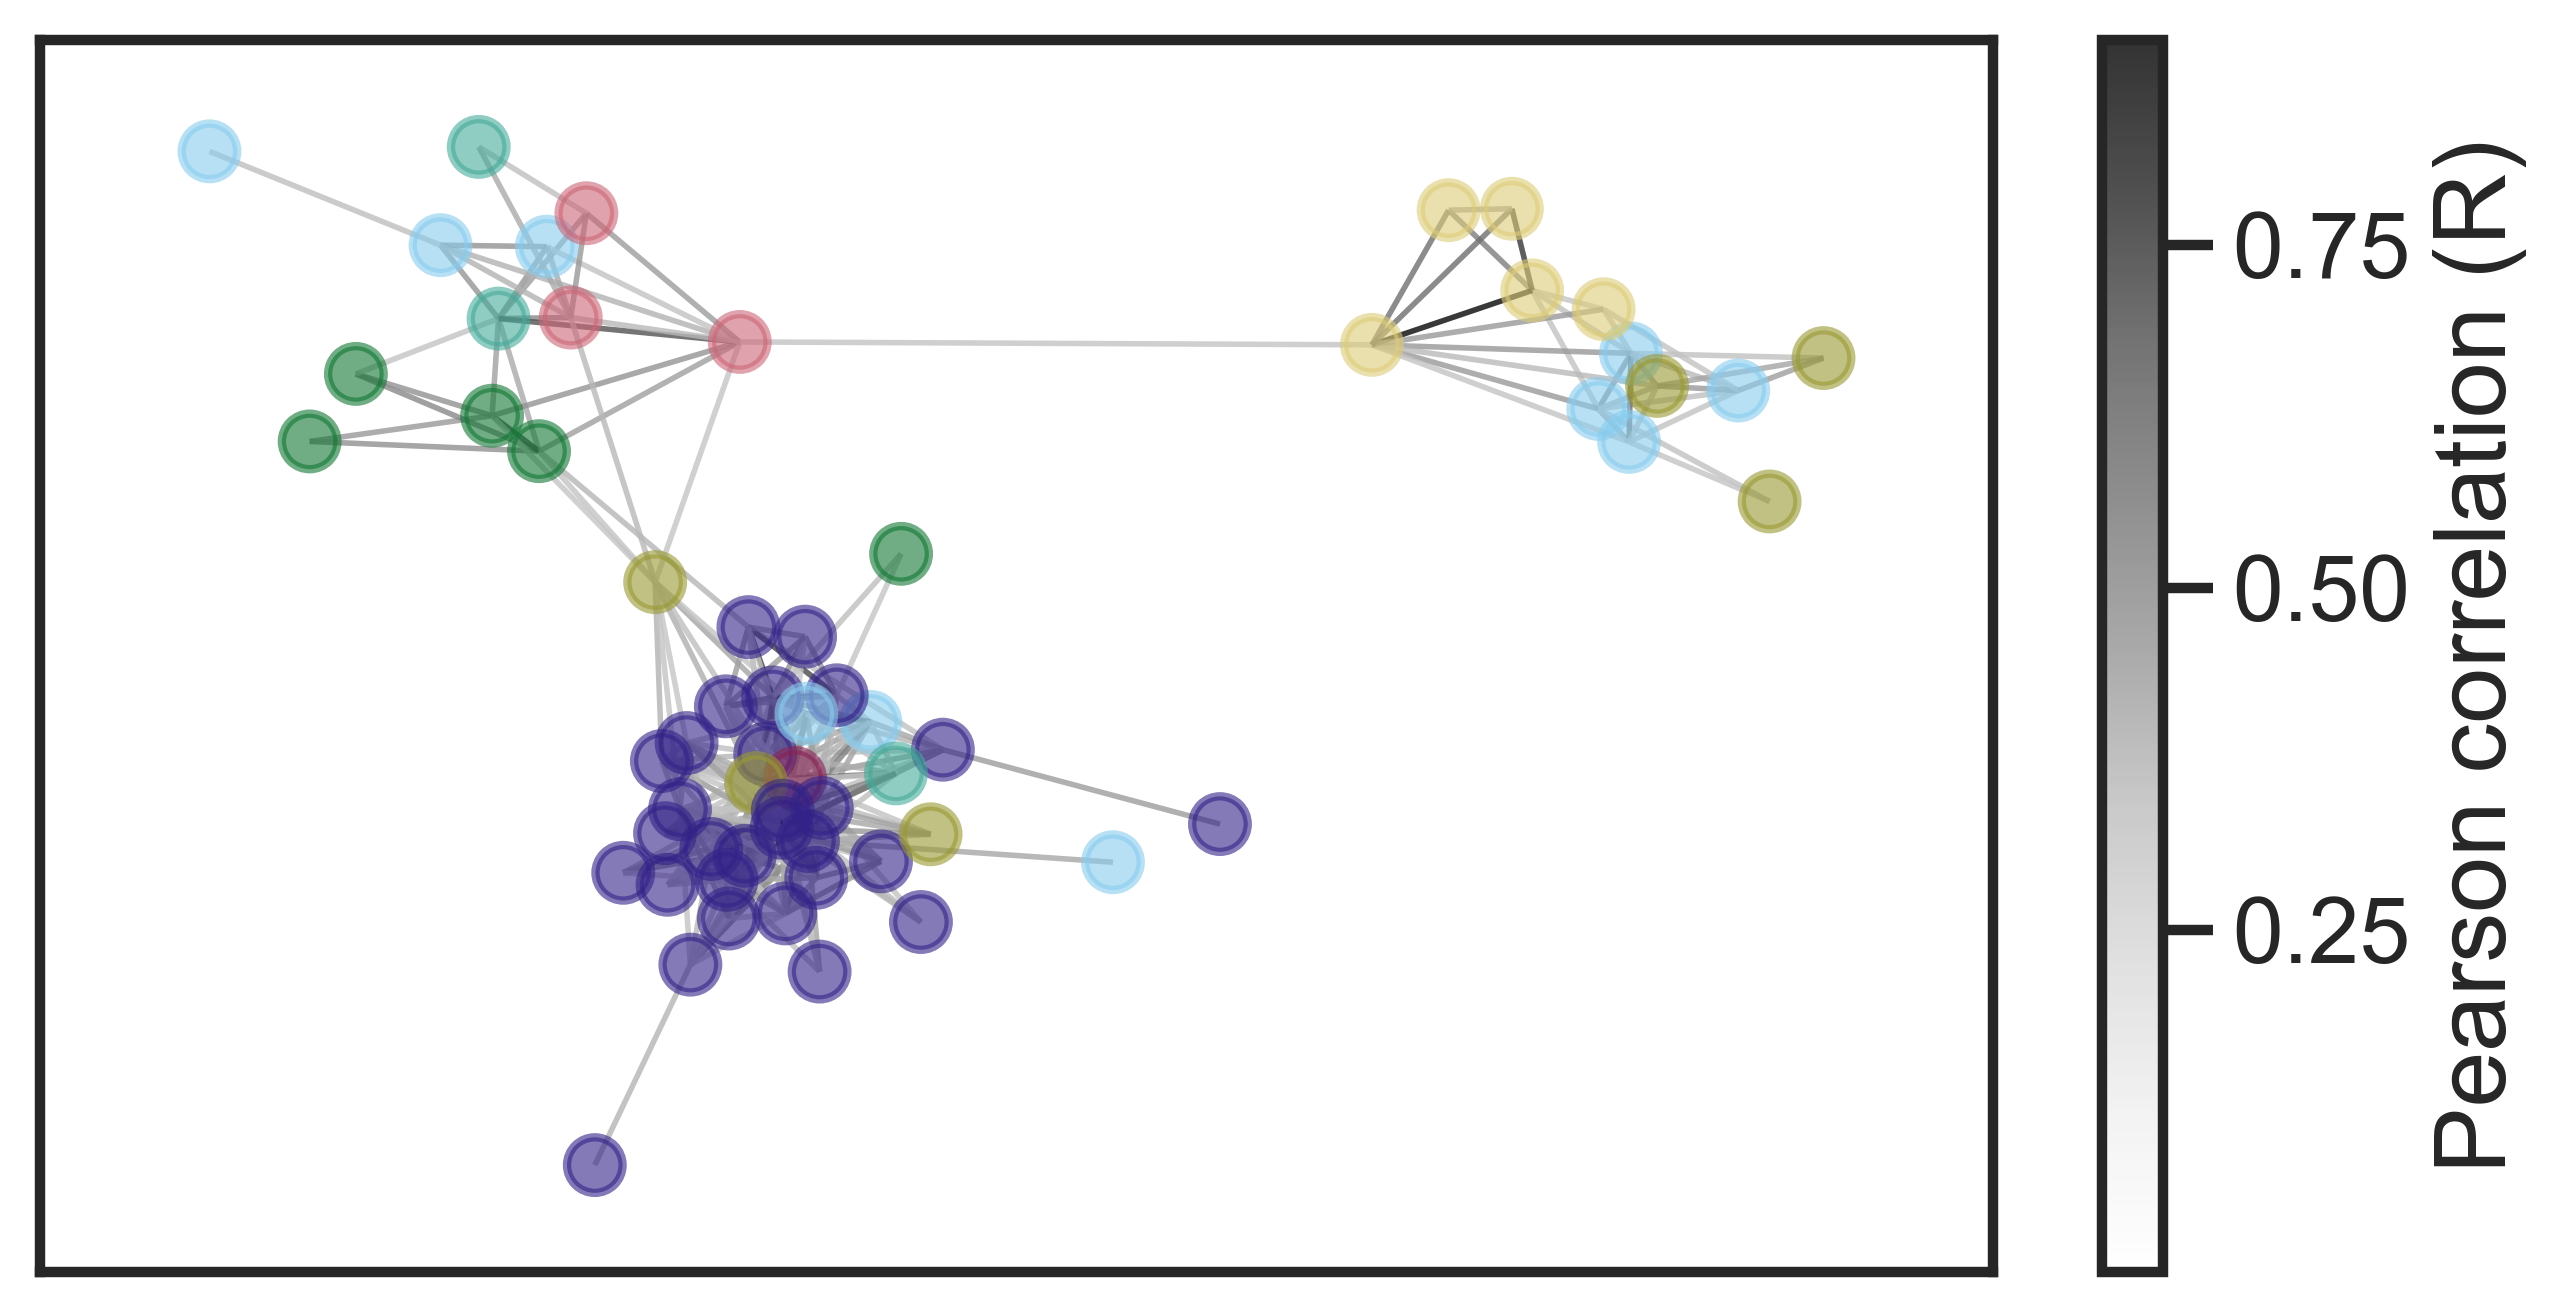

In [24]:
corr_filt = coabundance_df.loc[(coabundance_df['cell_line']=='IGR-OV1') &
                               (coabundance_df['corr']>= 0.3)]

corr_colors = {'nodes': {}, 'edges': {}, 'width': {}}

for index, row in corr_filt.iterrows():
    if row['col1'] not in corr_colors['nodes']: 
        corr_colors['nodes'][row['col1']] = utils.get_color_by_class(metabolite_ID.loc[metabolite_ID.ion==row['col1'],
                                                                     'class'].values[0])
    if row['col2'] not in corr_colors['nodes']: 
        corr_colors['nodes'][row['col2']] = utils.get_color_by_class(metabolite_ID.loc[metabolite_ID.ion==row['col2'],
                                                                     'class'].values[0])
    edge = tuple(sorted([row['col1'], row['col2']]))
    if edge not in corr_colors['edges']:
        corr_colors['edges'][edge] = row['corr']

plt.figure(figsize=(7, 4))
G = nx.from_pandas_edgelist(corr_filt, source='col1', target='col2')
nodes_color = [corr_colors['nodes'][n] for n in list(G.nodes)]
edges_color = [corr_colors['edges'][tuple(sorted(n))] for n in list(G.edges)]
pos = nx.spring_layout(G, seed = 1)
ec = nx.draw_networkx_edges(G, pos, alpha=0.8, edge_cmap=plt.cm.get_cmap('Greys'), edge_color=edges_color, edge_vmin=0, edge_vmax=0.9)
nc = nx.draw_networkx_nodes(G, pos, alpha=0.6, node_size=100, node_color=nodes_color)
plt.colorbar(ec, fraction=0.05, aspect=20, shrink=1, ticks=[0.25,0.5,0.75,1.0], label='Pearson correlation (R)')

plt.savefig(plots_path / 'panel_D_IGR-OV1.png', bbox_inches='tight')
plt.savefig(plots_path / 'panel_D_IGR-OV1.svg', bbox_inches='tight')

#### MALME-3M

/var/folders/yd/30x9k4ks4xgcqd7x9_jk19c40000gn/T/ipykernel_60115/1823713126.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ec = nx.draw_networkx_edges(G, pos, alpha=0.8, edge_cmap=plt.cm.get_cmap('Greys'), edge_color=edges_color, edge_vmin=0, edge_vmax=0.9)


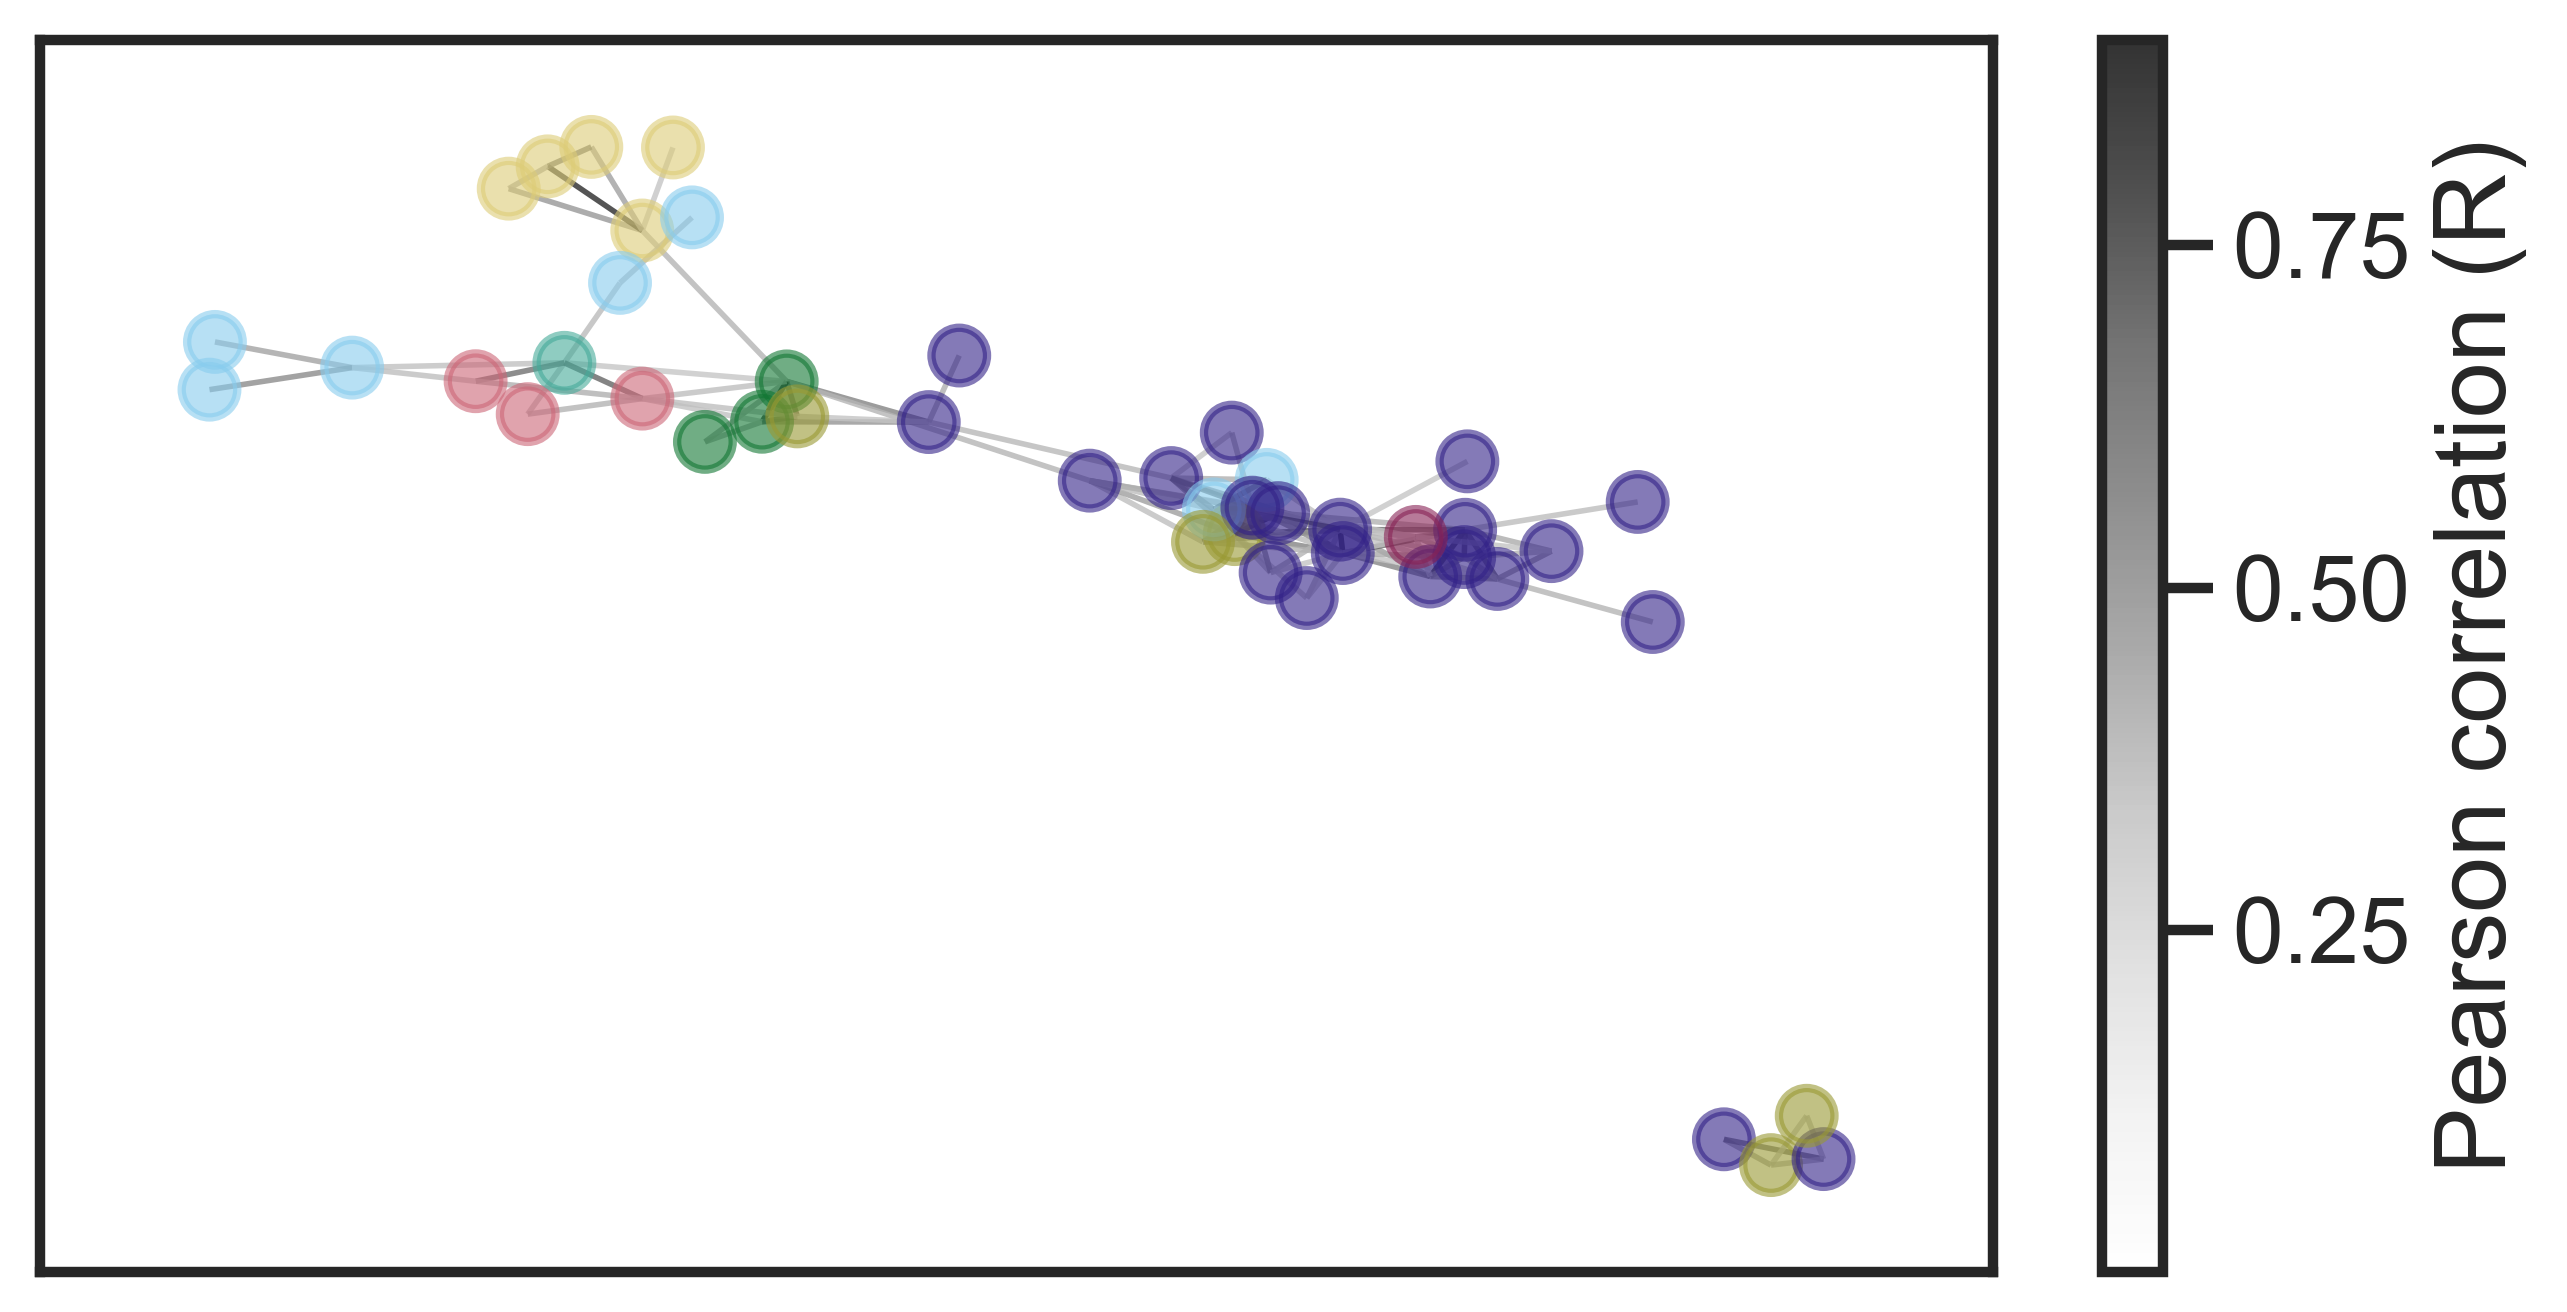

In [25]:
corr_filt = coabundance_df.loc[(coabundance_df['cell_line']=='MALME-3M') &
                               (coabundance_df['corr']>= 0.3)]

corr_colors = {'nodes': {}, 'edges': {}, 'width': {}}

for index, row in corr_filt.iterrows():
    if row['col1'] not in corr_colors['nodes']: 
        corr_colors['nodes'][row['col1']] = utils.get_color_by_class(metabolite_ID.loc[metabolite_ID.ion==row['col1'],
                                                                     'class'].values[0])
    if row['col2'] not in corr_colors['nodes']: 
        corr_colors['nodes'][row['col2']] = utils.get_color_by_class(metabolite_ID.loc[metabolite_ID.ion==row['col2'],
                                                                     'class'].values[0])
    edge = tuple(sorted([row['col1'], row['col2']]))
    if edge not in corr_colors['edges']:
        corr_colors['edges'][edge] = row['corr']

plt.figure(figsize=(7, 4))
G = nx.from_pandas_edgelist(corr_filt, source='col1', target='col2')
nodes_color = [corr_colors['nodes'][n] for n in list(G.nodes)]
edges_color = [corr_colors['edges'][tuple(sorted(n))] for n in list(G.edges)]
pos = nx.spring_layout(G, seed = 1)
ec = nx.draw_networkx_edges(G, pos, alpha=0.8, edge_cmap=plt.cm.get_cmap('Greys'), edge_color=edges_color, edge_vmin=0, edge_vmax=0.9)
nc = nx.draw_networkx_nodes(G, pos, alpha=0.6, node_size=100, node_color=nodes_color)
plt.colorbar(ec, fraction=0.05, aspect=20, shrink=1, ticks=[0.25,0.5,0.75,1.0], label='Pearson correlation (R)')

plt.savefig(plots_path / 'panel_D_MALME-3M.png', bbox_inches='tight')
plt.savefig(plots_path / 'panel_D_MALME-3M.svg', bbox_inches='tight')

#### NCI-H460

/var/folders/yd/30x9k4ks4xgcqd7x9_jk19c40000gn/T/ipykernel_60115/2799133737.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ec = nx.draw_networkx_edges(G, pos, alpha=0.8, edge_cmap=plt.cm.get_cmap('Greys'), edge_color=edges_color, edge_vmin=0, edge_vmax=0.9)


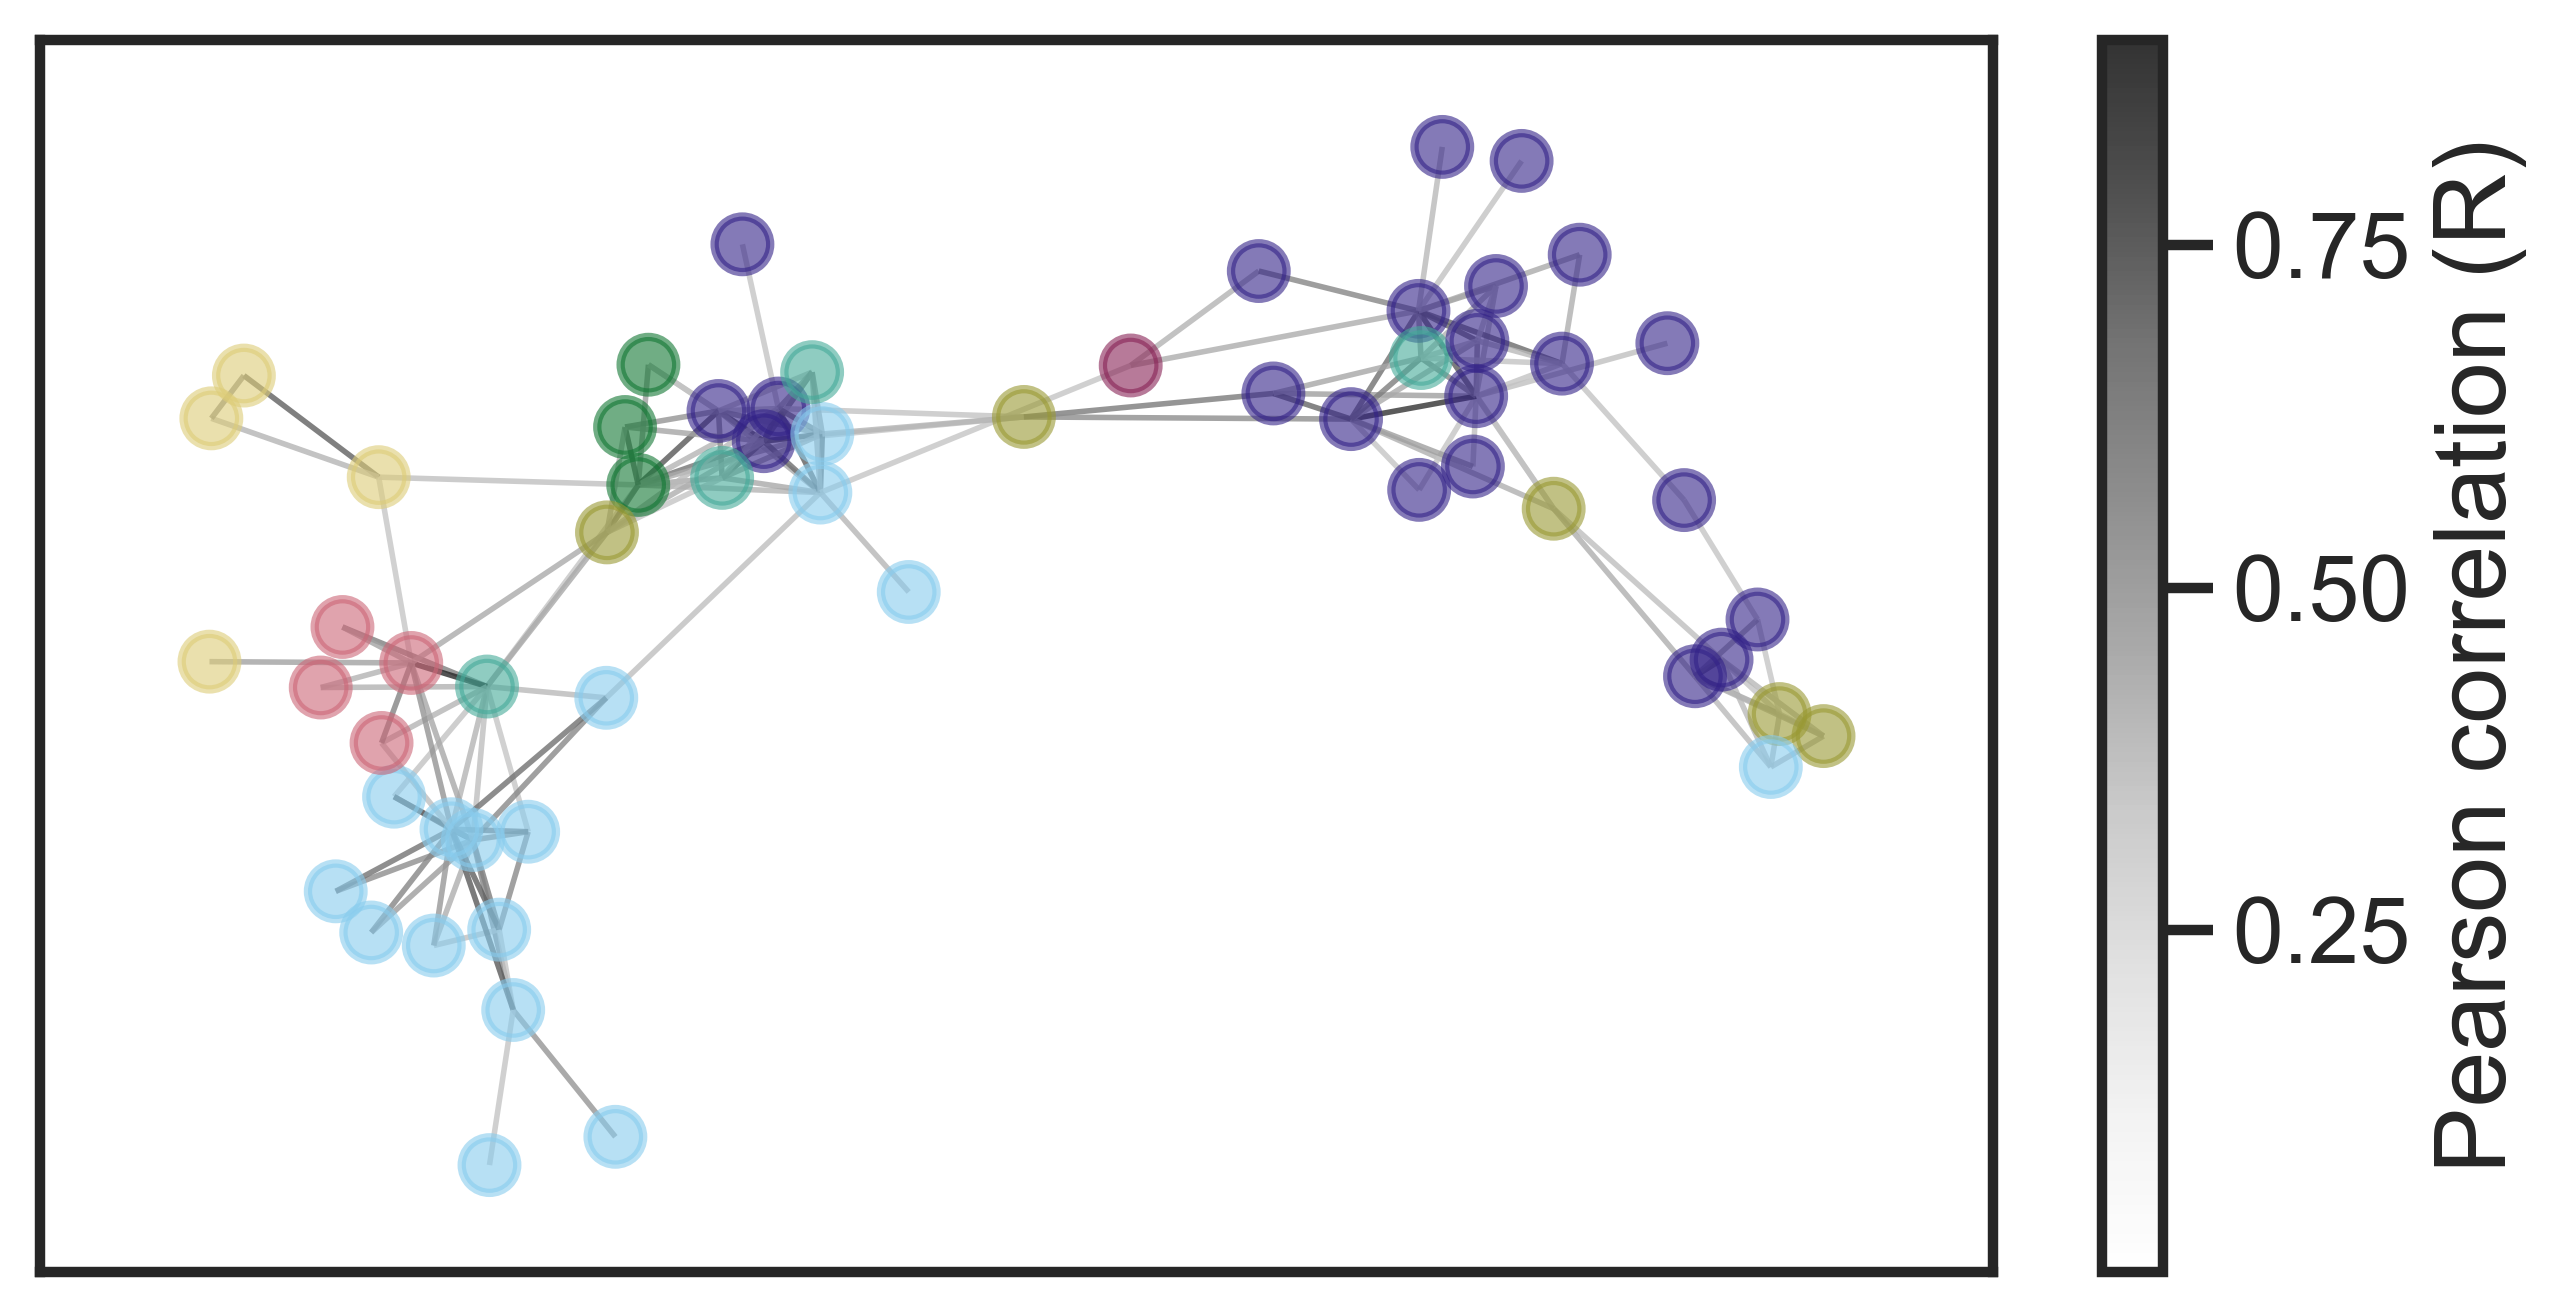

In [26]:
corr_filt = coabundance_df.loc[(coabundance_df['cell_line']=='NCI-H460') &
                               (coabundance_df['corr']>= 0.3)]

corr_colors = {'nodes': {}, 'edges': {}, 'width': {}}

for index, row in corr_filt.iterrows():
    if row['col1'] not in corr_colors['nodes']: 
        corr_colors['nodes'][row['col1']] = utils.get_color_by_class(metabolite_ID.loc[metabolite_ID.ion==row['col1'],
                                                                     'class'].values[0])
    if row['col2'] not in corr_colors['nodes']: 
        corr_colors['nodes'][row['col2']] = utils.get_color_by_class(metabolite_ID.loc[metabolite_ID.ion==row['col2'],
                                                                     'class'].values[0])
    edge = tuple(sorted([row['col1'], row['col2']]))
    if edge not in corr_colors['edges']:
        corr_colors['edges'][edge] = row['corr']

plt.figure(figsize=(7, 4))
G = nx.from_pandas_edgelist(corr_filt, source='col1', target='col2')
nodes_color = [corr_colors['nodes'][n] for n in list(G.nodes)]
edges_color = [corr_colors['edges'][tuple(sorted(n))] for n in list(G.edges)]
pos = nx.spring_layout(G, seed = 1)
ec = nx.draw_networkx_edges(G, pos, alpha=0.8, edge_cmap=plt.cm.get_cmap('Greys'), edge_color=edges_color, edge_vmin=0, edge_vmax=0.9)
nc = nx.draw_networkx_nodes(G, pos, alpha=0.6, node_size=100, node_color=nodes_color)
plt.colorbar(ec, fraction=0.05, aspect=20, shrink=1, ticks=[0.25,0.5,0.75,1.0], label='Pearson correlation (R)')

plt.savefig(plots_path / 'panel_D_NCI-H460.png', bbox_inches='tight')
plt.savefig(plots_path / 'panel_D_NCI-H460.svg', bbox_inches='tight')

#### OVCAR-5

/var/folders/yd/30x9k4ks4xgcqd7x9_jk19c40000gn/T/ipykernel_60115/4229458513.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ec = nx.draw_networkx_edges(G, pos, alpha=0.8, edge_cmap=plt.cm.get_cmap('Greys'), edge_color=edges_color, edge_vmin=0, edge_vmax=0.9)


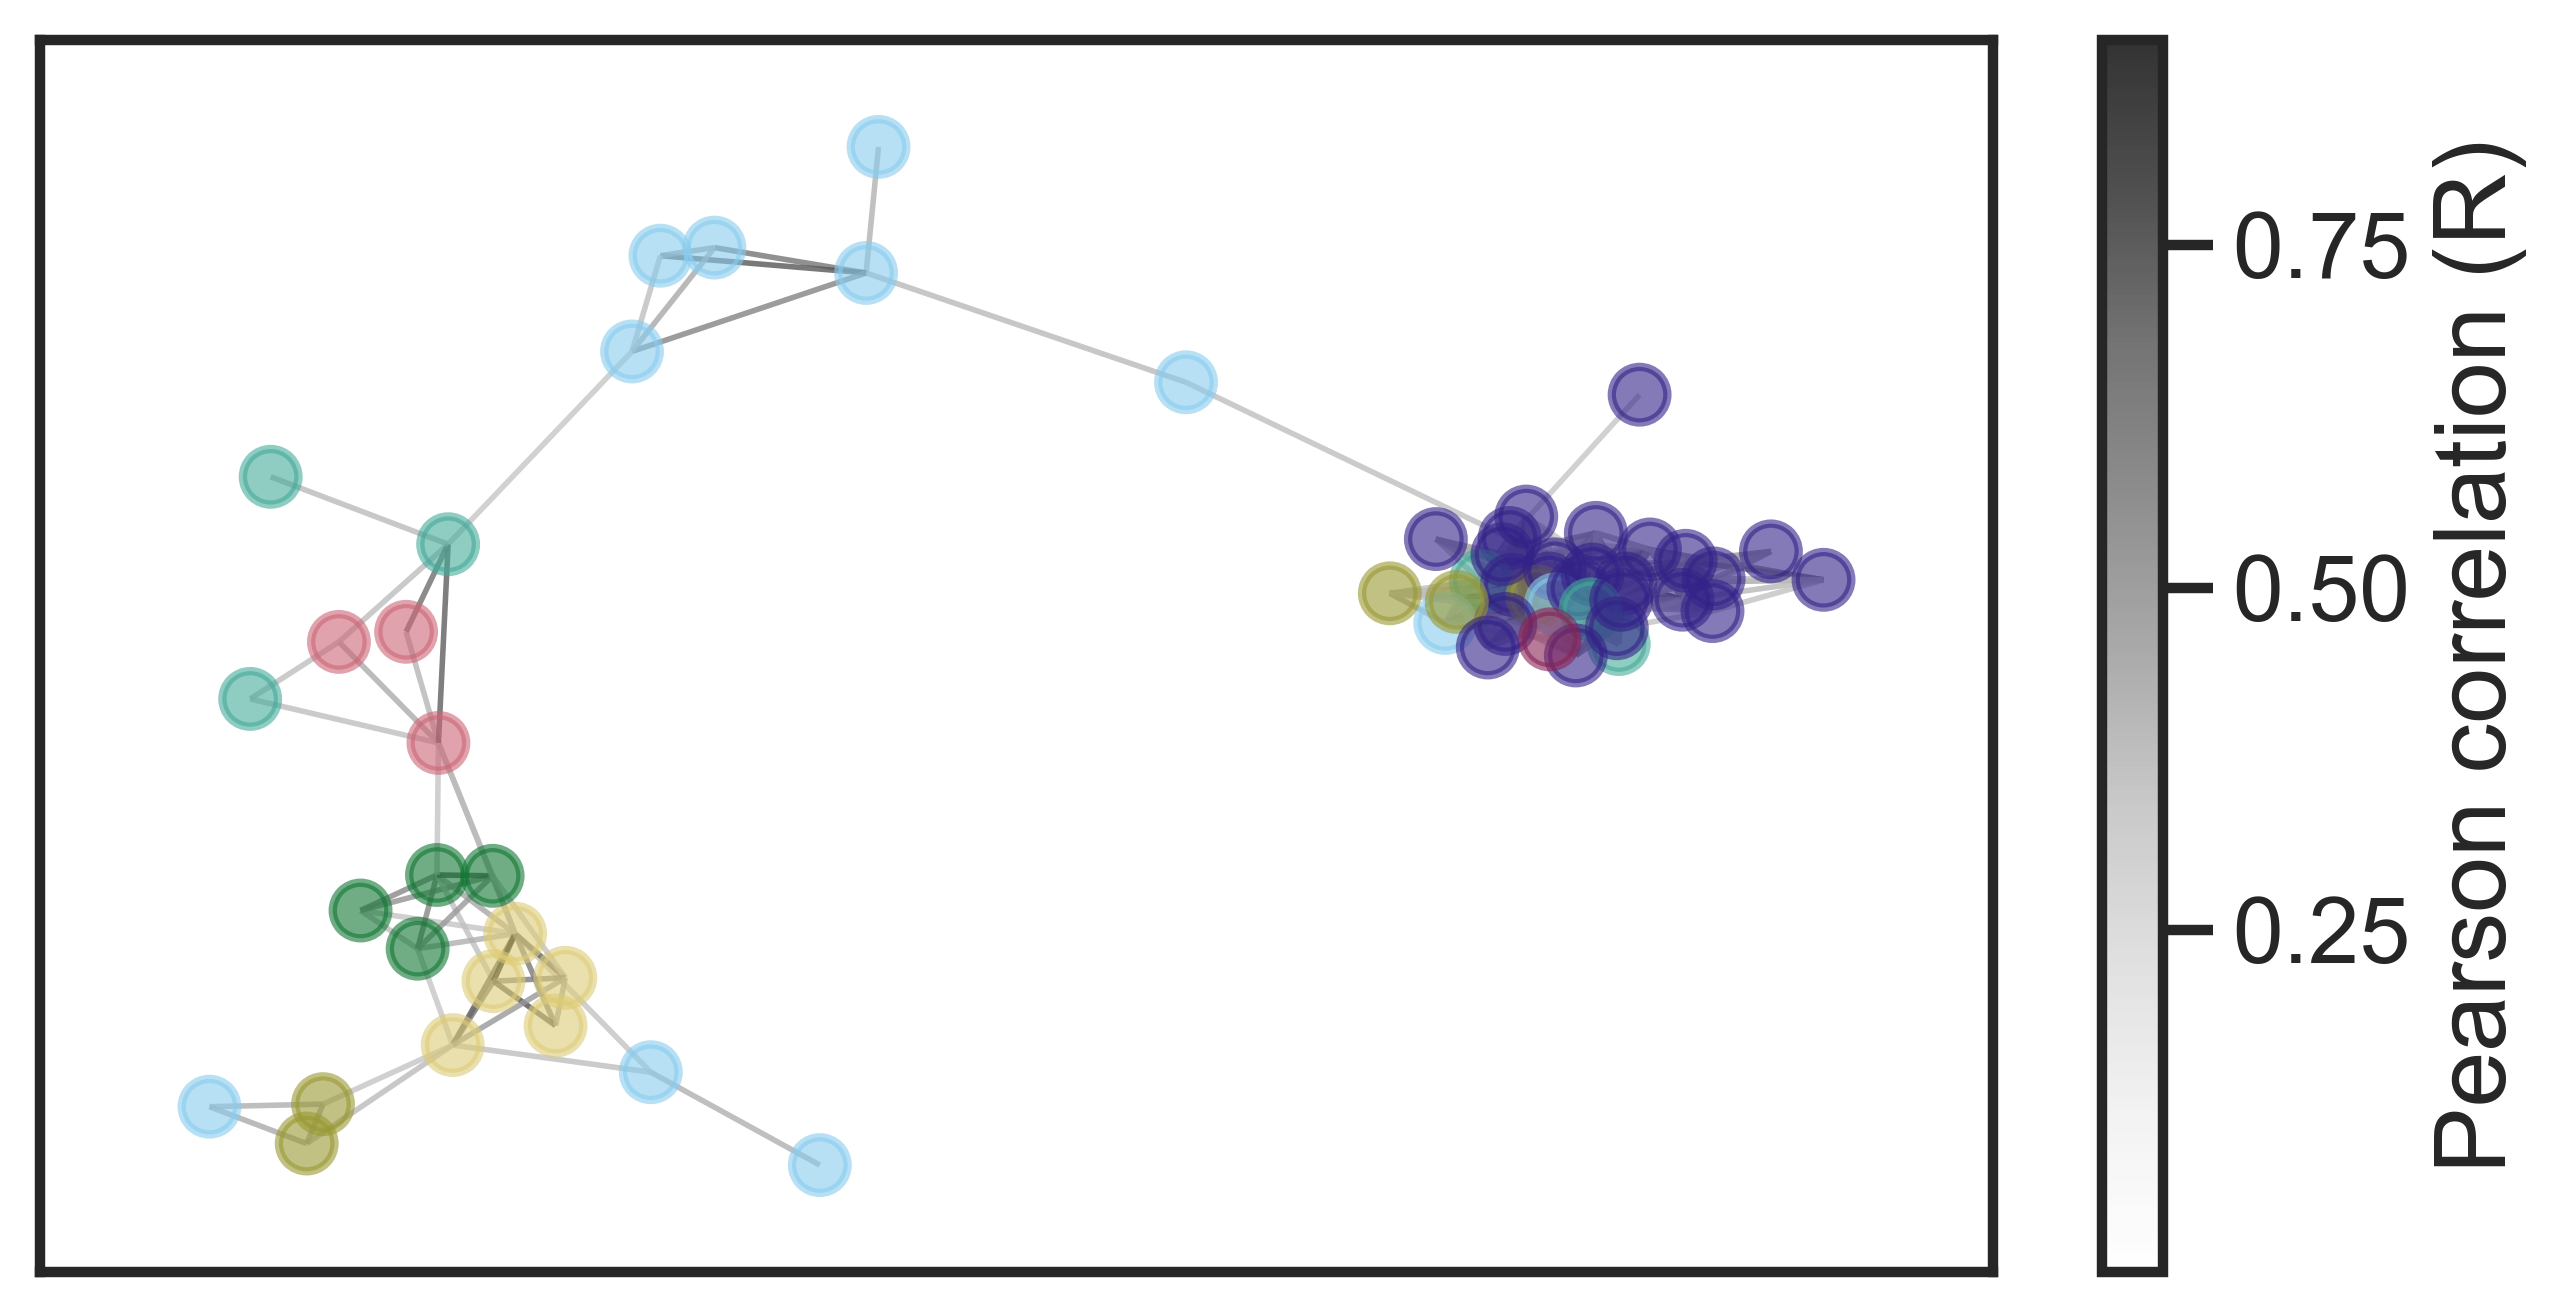

In [27]:
corr_filt = coabundance_df.loc[(coabundance_df['cell_line']=='OVCAR-5') &
                               (coabundance_df['corr']>= 0.3)]

corr_colors = {'nodes': {}, 'edges': {}, 'width': {}}

for index, row in corr_filt.iterrows():
    if row['col1'] not in corr_colors['nodes']: 
        corr_colors['nodes'][row['col1']] = utils.get_color_by_class(metabolite_ID.loc[metabolite_ID.ion==row['col1'],
                                                                     'class'].values[0])
    if row['col2'] not in corr_colors['nodes']: 
        corr_colors['nodes'][row['col2']] = utils.get_color_by_class(metabolite_ID.loc[metabolite_ID.ion==row['col2'],
                                                                     'class'].values[0])
    edge = tuple(sorted([row['col1'], row['col2']]))
    if edge not in corr_colors['edges']:
        corr_colors['edges'][edge] = row['corr']

plt.figure(figsize=(7, 4))
G = nx.from_pandas_edgelist(corr_filt, source='col1', target='col2')
nodes_color = [corr_colors['nodes'][n] for n in list(G.nodes)]
edges_color = [corr_colors['edges'][tuple(sorted(n))] for n in list(G.edges)]
pos = nx.spring_layout(G, seed = 1)
ec = nx.draw_networkx_edges(G, pos, alpha=0.8, edge_cmap=plt.cm.get_cmap('Greys'), edge_color=edges_color, edge_vmin=0, edge_vmax=0.9)
nc = nx.draw_networkx_nodes(G, pos, alpha=0.6, node_size=100, node_color=nodes_color)
plt.colorbar(ec, fraction=0.05, aspect=20, shrink=1, ticks=[0.25,0.5,0.75,1.0], label='Pearson correlation (R)')

plt.savefig(plots_path / 'panel_D_OVCAR-5.png', bbox_inches='tight')
plt.savefig(plots_path / 'panel_D_OVCAR-5.svg', bbox_inches='tight')

## Panel E

### Set paths

In [28]:
#input
data_dir = Path(r'../data')
data_path = data_dir / 'SC2_co-abundance.csv'
metabolite_path = data_dir / 'SC2_metabolite_IDs.csv'

#output
plots_path =  Path(r'../') / 'figures' / 'figure_5'
plots_path.mkdir(parents=True, exist_ok=True)
sc.settings.figdir = plots_path

### Load data

In [29]:
#load data file
coabundance_df =  pd.read_csv(data_path)

#load metabolites file
metabolite_ID = pd.read_csv(metabolite_path)

In [30]:
corr_filt = coabundance_df.loc[(coabundance_df['corr']>= 0.3)]
cell_name = ['A498','BT-549','HOP-62','HS 578T','HT29','HeLa','IGR-OV1','MALME-3M','NCI-H460','OVCAR-5']

In [31]:
G_graphs = {}
metric_df = []

for cell_line in cell_name:
    corr_sets = {}
    cell_df = corr_filt.loc[corr_filt['cell_line']==cell_line]
    
    for index, row in cell_df.iterrows():
        class_set = utils.get_set_by_class(metabolite_ID.loc[metabolite_ID.ion==row['col1'],'class'].values[0])
        utils.insert_set(data=corr_sets, class_set=class_set, ion=row['col1'])

        class_set = utils.get_set_by_class(metabolite_ID.loc[metabolite_ID.ion==row['col2'],'class'].values[0])
        utils.insert_set(data=corr_sets, class_set=class_set, ion=row['col2'])
    
    metric_df.extend(utils.calculate_metrics(data = cell_df, sets = corr_sets, cell_line = cell_line))

metric_df = pd.DataFrame(metric_df)

### Heat map

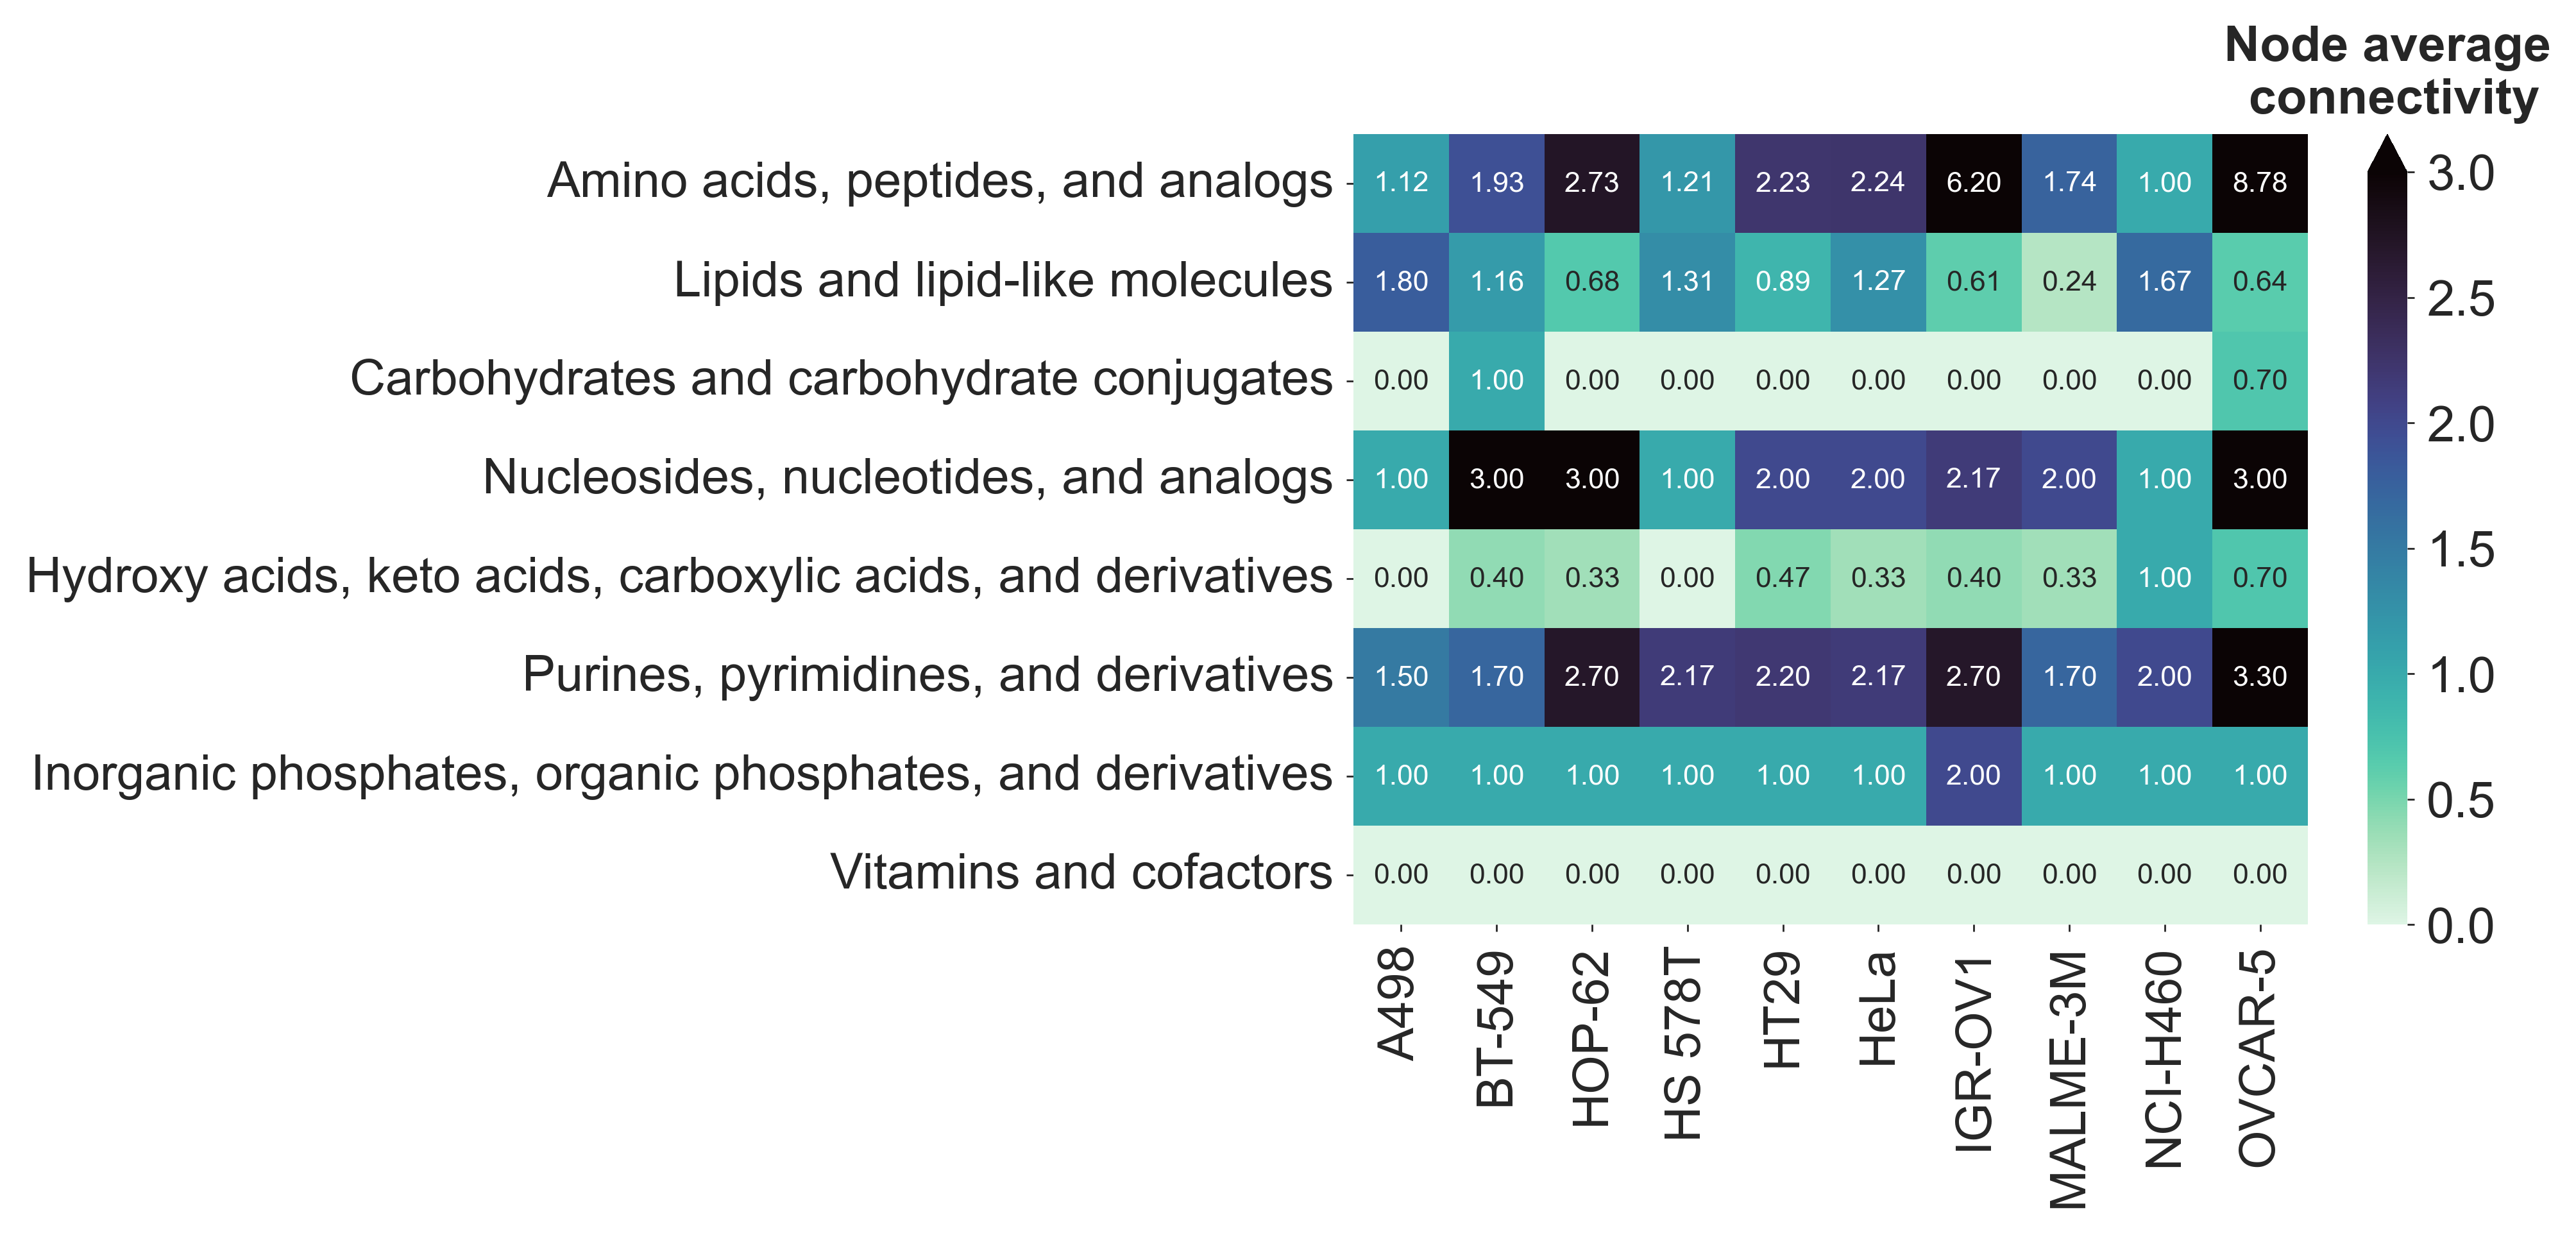

In [32]:
connectivity = metric_df.pivot(index='class', columns='cell_line', values='avg_connectivity').fillna(0)
connectivity.index = pd.CategoricalIndex(connectivity.index,
                                         categories=['Amino acids, peptides, and analogs',
                                                    'Lipids and lipid-like molecules',
                                                    'Carbohydrates and carbohydrate conjugates',
                                                    'Nucleosides, nucleotides, and analogs',
                                                    'Hydroxy acids, keto acids, carboxylic acids, and derivatives',
                                                    'Purines, pyrimidines, and derivatives',
                                                    'Inorganic phosphates, organic phosphates, and derivatives',
                                                    'Vitamins and cofactors',
                                                    'Others'])
        
connectivity.sort_index(level=0, inplace=True)
plt.figure(figsize=(6, 4))
ax = sns.heatmap(connectivity, 
                 annot=True, 
                 cmap='mako_r', 
                 annot_kws={'fontsize':8}, vmax=3, fmt='.2f', cbar_kws={'extend':'max'})

cax=ax.figure.axes[-1]
pax=ax.figure.axes[0]
pax.tick_params(width=0.5, length=2,labelsize=14)
cax.tick_params(width=0.5, length=2,labelsize=14)
cax.set_title('Node average\n connectivity', size=14, weight='bold')
plt.ylabel('')
plt.xlabel('')

plt.savefig(plots_path / 'panel_E.png', bbox_inches='tight')
plt.savefig(plots_path / 'panel_E.svg', bbox_inches='tight')